In [1]:
import numpy as np
import os

import geopandas as gpd
import pandas as pd
import pickle
import sklearn
import matplotlib.pyplot as plt
import urllib.request

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel

In [2]:
data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'

with open(f'{data_dir}g_df_ucdp_prio.pkl', 'rb') as file:
    df = pickle.load(file)

In [3]:
print(f"{df['year'].min()},{df['year'].max()}")

1989,2019


In [4]:
12 * (df['year'].max() - df['year'].min())

360

In [5]:
df.groupby('gid').count()['month_id'].unique() # every gid should have 360 month ids....

array([372])

In [6]:
df.loc[df['log_best'] > 8, 'gid'].unique().shape

(32,)

In [7]:
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# world.to_crs(df.crs)

# for i in sorted(df['month_id'].unique())[300:305]:

#     print(f"{i}: {df[df['month_id'] == i]['year_months_start'].unique().item()}")
#     fig, ax = plt.subplots(figsize = (20,20))
#     df[df['month_id'] == i].plot(ax=ax, column = 'log_best')
#     world.plot(facecolor='none', edgecolor='black', ax=ax)
#     plt.show()

## get relevant area

In [8]:
def get_cshapes():
    location = '/home/simon/Documents/Bodies/data/PRIO' 
    path_cshapes = location + "/CShapes-2.0.csv"
    
    if os.path.isfile(path_cshapes) == True:
        print('file already downloaded')
        cshapes = pd.read_csv(path_cshapes)


    else: 
        print('Beginning file download CShapes...')

        url_cshapes = 'https://icr.ethz.ch/data/cshapes/CShapes-2.0.csv'
    
        urllib.request.urlretrieve(url_cshapes, path_cshapes)
        cshapes = pd.read_csv(path_cshapes)

    return cshapes

In [9]:
cshapes = get_cshapes()
cshapes_mask = ['Gaza', 'West Bank', 'Jordan', 'Palestine', 'Israel', 'Iraq', 'Syria', 'Lebanon', 'Turkey (Ottoman Empire)']
gwno_to_keep = cshapes.loc[cshapes['cntry_name'].isin(cshapes_mask), 'gwcode'].unique()

file already downloaded


In [10]:
df_sub = df[df['gwno'].isin(gwno_to_keep)].copy()

In [11]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
country_mask_world = ['Israel', 'Palestine', 'Jordan', 'Iraq', 'Syria', 'Turkey', 'Lebanon']
sub_world = world[world['name'].isin(country_mask_world)].copy()


# for i in sorted(df_sub['month_id'].unique())[180:185]:

#     print(f"{i}: {df_sub[df_sub['month_id'] == i]['year_months_start'].unique().item()}")

#     fig, ax = plt.subplots(figsize = (20,20))

#     ax.set_aspect('equal')

#     #vmax = combined_df['log_best'].max()
#     vmax = df_sub.loc[(df_sub['gwno'].isin(gwno_to_keep)) & (df_sub['month_id'].isin(np.arange(180, 185+1, 1))), 'log_best'].max()

#     df_sub[(df_sub['gwno'].isin(gwno_to_keep)) & (df_sub['month_id'] == i)].plot(ax = ax, column = 'log_best', cmap = 'rainbow', vmin = 0, vmax = vmax)
#     sub_world.plot(facecolor='none', edgecolor='black', ax=ax)
#     plt.show()

# estimate GP

In [21]:
def esstimate_kernel(df_sub):
    
    test_gids = df_sub.loc[df_sub['log_best'] > 6, 'gid'].unique()
    n_timelines = test_gids.shape[0]

    print(f'number of timelines used: {n_timelines}')

    mask = df_sub['gid'].isin(test_gids)
    df_test2 = df_sub[mask].copy()
    df_test2.sort_values(['month_id', 'gid'], inplace = True) # this make reshape work

    y = np.array(df_test2['log_best']).reshape(-1, n_timelines)
    x = np.array(df_test2[['month_id']]).reshape(-1, n_timelines)

    # GP
    noise_std = y.std()

    kernel_short = ConstantKernel() * Matern(length_scale=4.0, length_scale_bounds=(1, 32.0), nu=1.5) # nu = 1.5 gives v = 3/2 so matern32
    kernel_long = ConstantKernel() * RBF(length_scale=20.0, length_scale_bounds=(32, 320))

    kernel =  kernel_short + kernel_long + WhiteKernel(noise_level=noise_std)

    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    gaussian_process.fit(x, y)
    gaussian_process.kernel_

    return gaussian_process.kernel_

In [22]:
kernel = esstimate_kernel(df_sub)
print(kernel)

number of timelines used: 43
0.541**2 * Matern(length_scale=26.7, nu=1.5) + 1.35**2 * RBF(length_scale=234) + WhiteKernel(noise_level=0.398)


In [23]:
kernel.set_params(k1__k1__k1__constant_value_bounds = 'fixed', 
                  k1__k1__k2__length_scale_bounds = 'fixed', 
                  k1__k2__k1__constant_value_bounds = 'fixed', 
                  k1__k2__k2__length_scale_bounds = 'fixed', 
                  k2__noise_level_bounds = 'fixed' )

0.541**2 * Matern(length_scale=26.7, nu=1.5) + 1.35**2 * RBF(length_scale=234) + WhiteKernel(noise_level=0.398)

In [24]:
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

n_timelines_new = df_sub['gid'].unique().shape[0]
df_sub.sort_values(['month_id', 'gid'], inplace = True) # this make reshape work
x_new = np.array(df_sub[['month_id']]).reshape(-1, n_timelines_new)
y_new = np.array(df_sub[['log_best']]).reshape(-1, n_timelines_new)

gaussian_process.fit(x_new,y_new) #this refit is only needed bacouse you have more timelines here and treat them aas features...
gaussian_process.kernel_

0.541**2 * Matern(length_scale=26.7, nu=1.5) + 1.35**2 * RBF(length_scale=234) + WhiteKernel(noise_level=0.398)

In [25]:
mean_prediction, std_prediction = gaussian_process.predict(x_new, return_std=True)

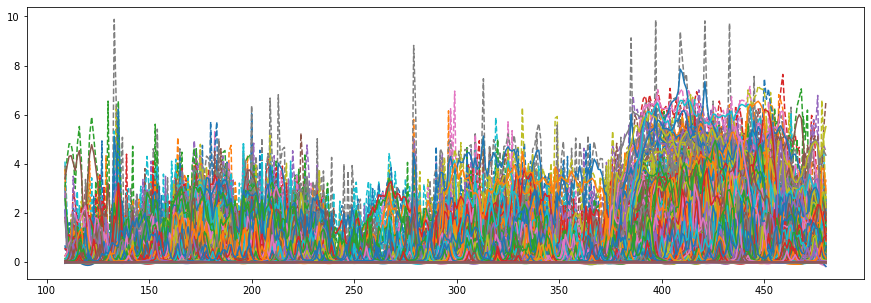

In [26]:
plt.figure(figsize =  [15,5])
plt.plot(x_new, y_new, '--', label="log best")
plt.plot(x_new, mean_prediction, label="Mean prediction")
plt.show()

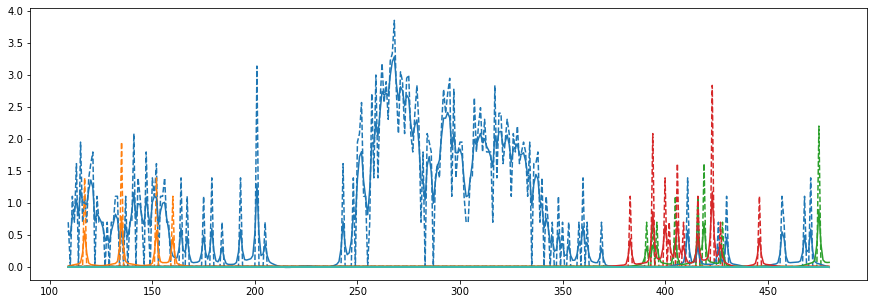

In [27]:
plt.figure(figsize =  [15,5])
plt.plot(x_new[:,90:100], y_new[:,90:100], '--', label="log best")
plt.plot(x_new[:,90:100], mean_prediction[:,90:100], label="Mean prediction")
plt.show()

In [28]:
df_sub['tce'] = mean_prediction.reshape(-1,1)
df_sub['tce_std'] = std_prediction.reshape(-1,1)

289: 2004-01


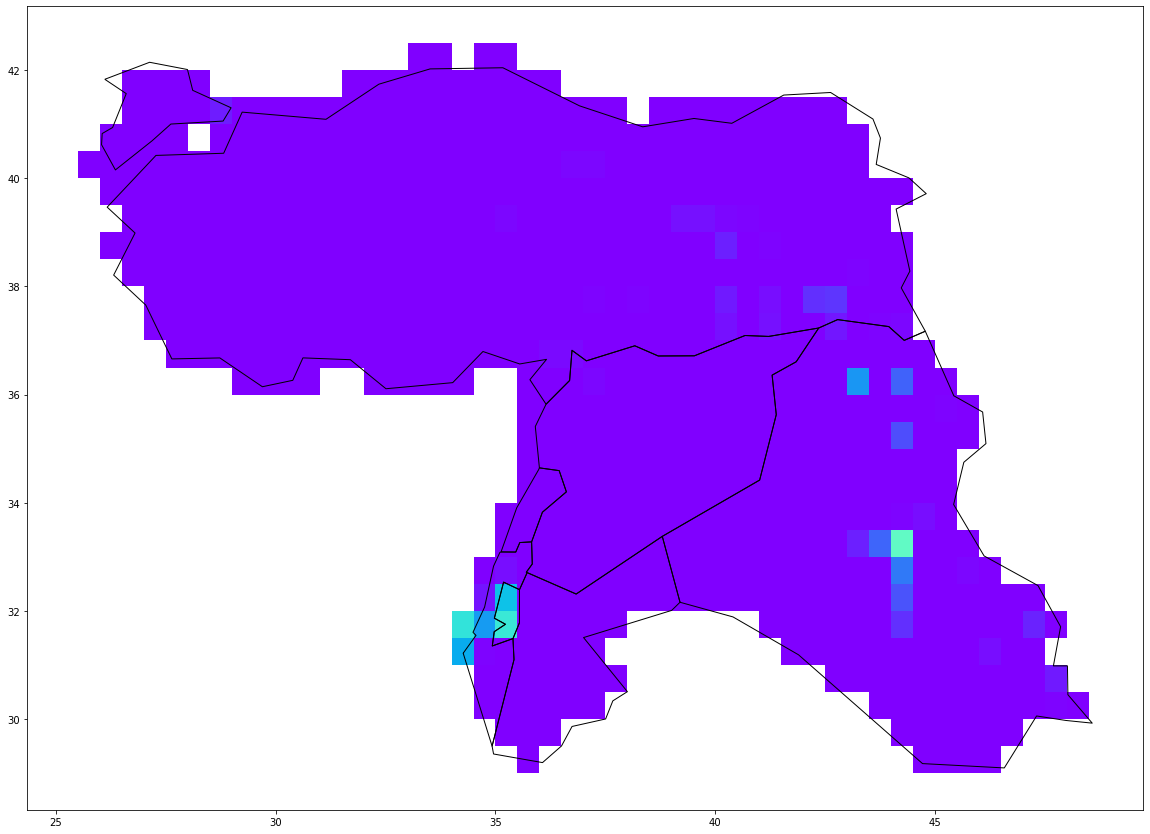

290: 2004-02


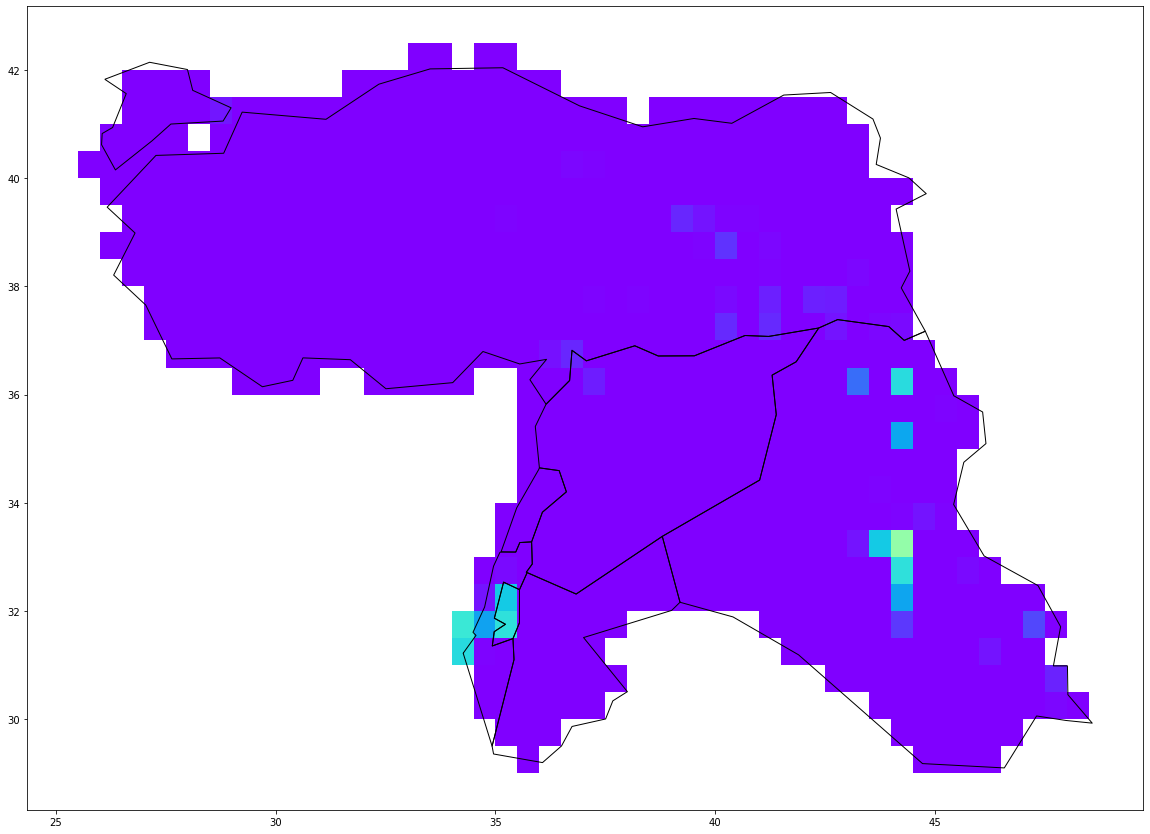

291: 2004-03


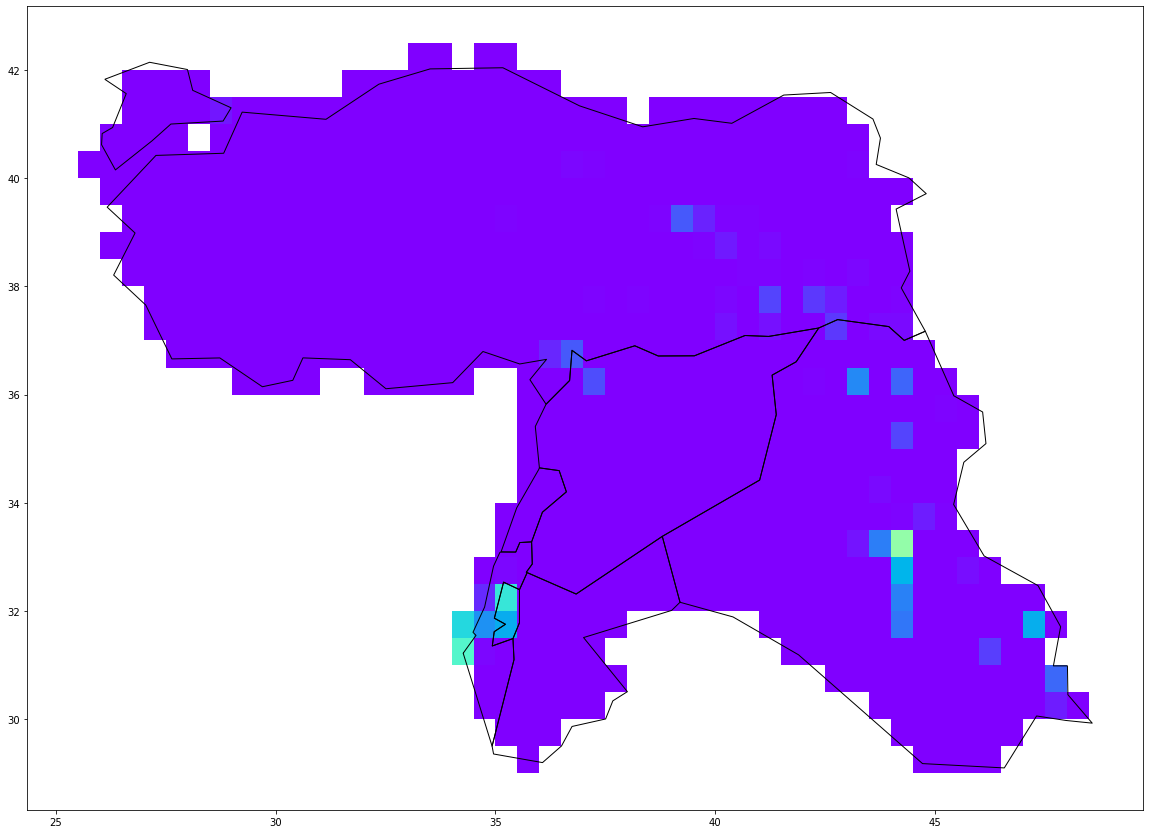

292: 2004-04


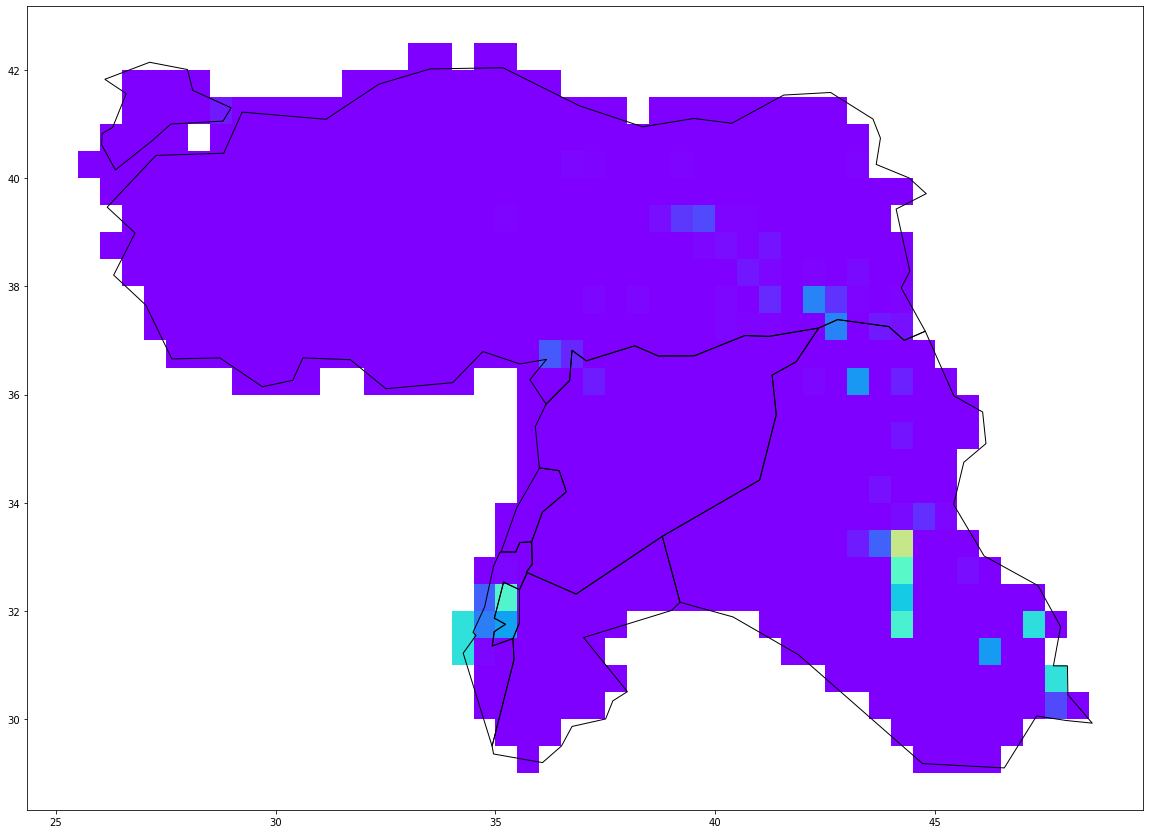

293: 2004-05


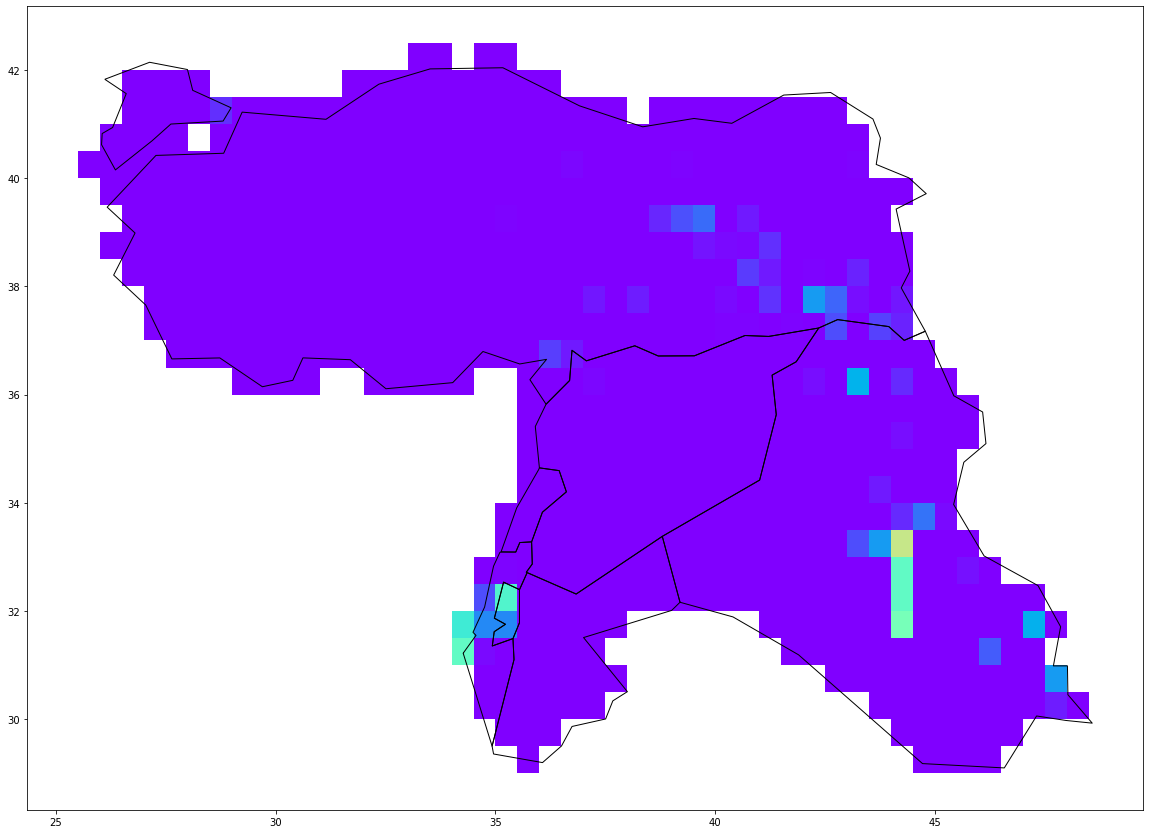

294: 2004-06


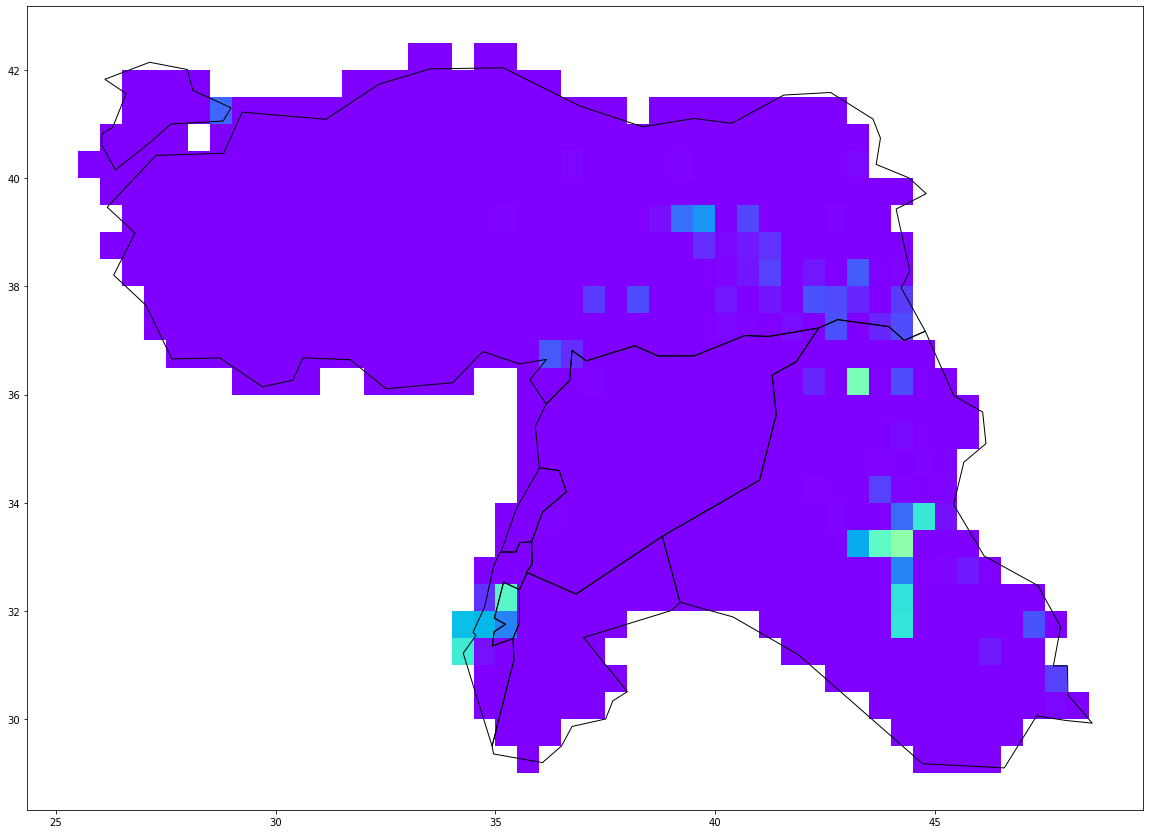

295: 2004-07


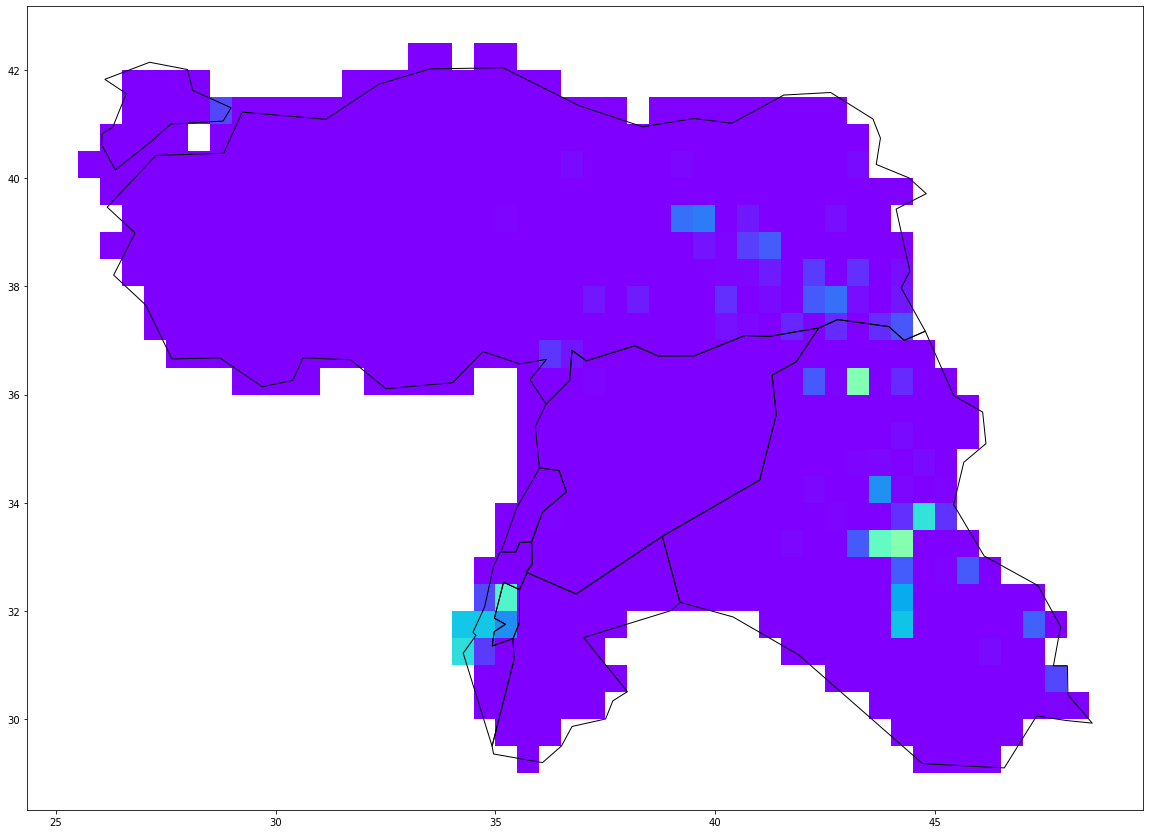

296: 2004-08


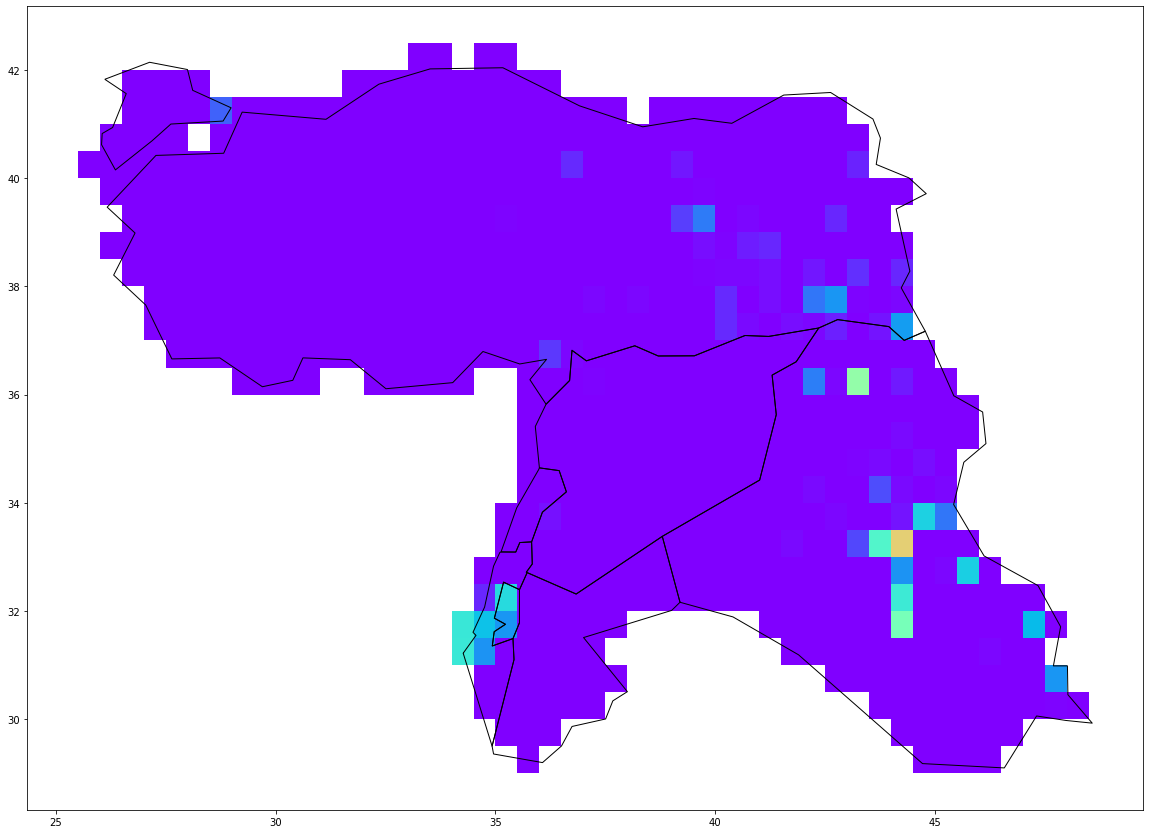

297: 2004-09


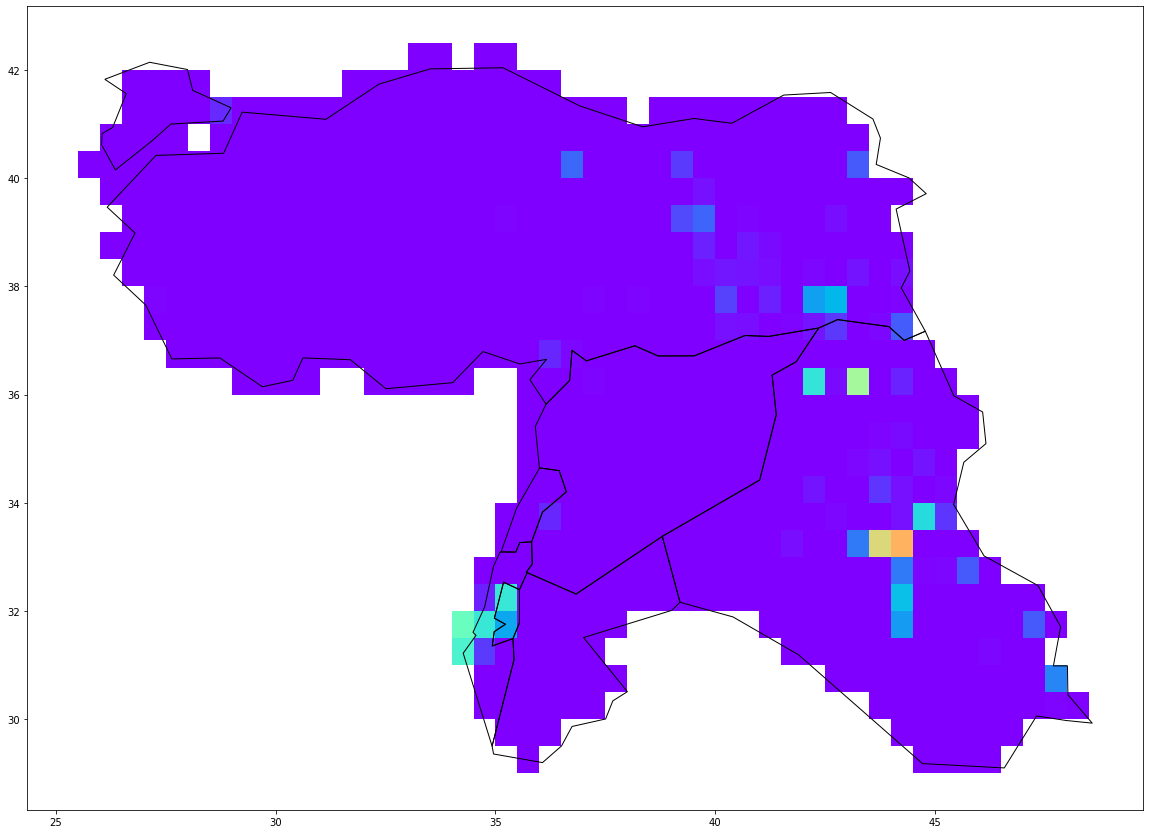

298: 2004-10


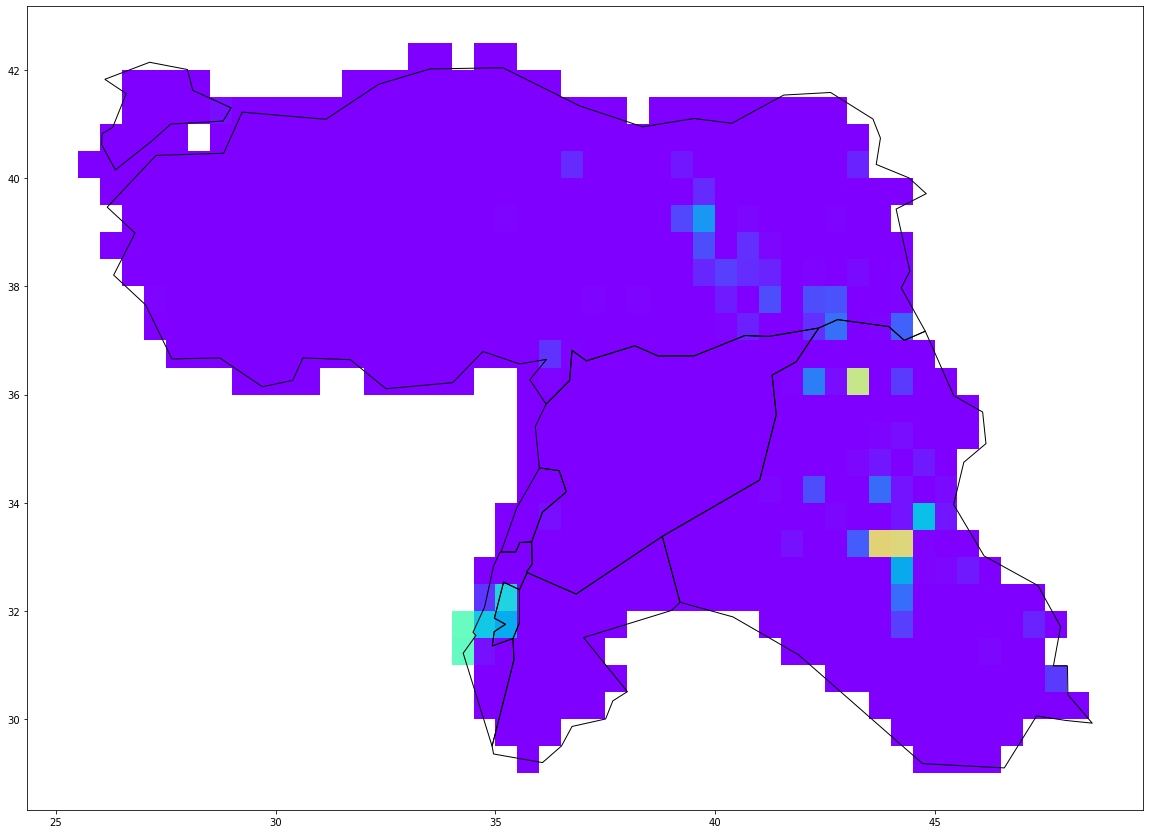

299: 2004-11


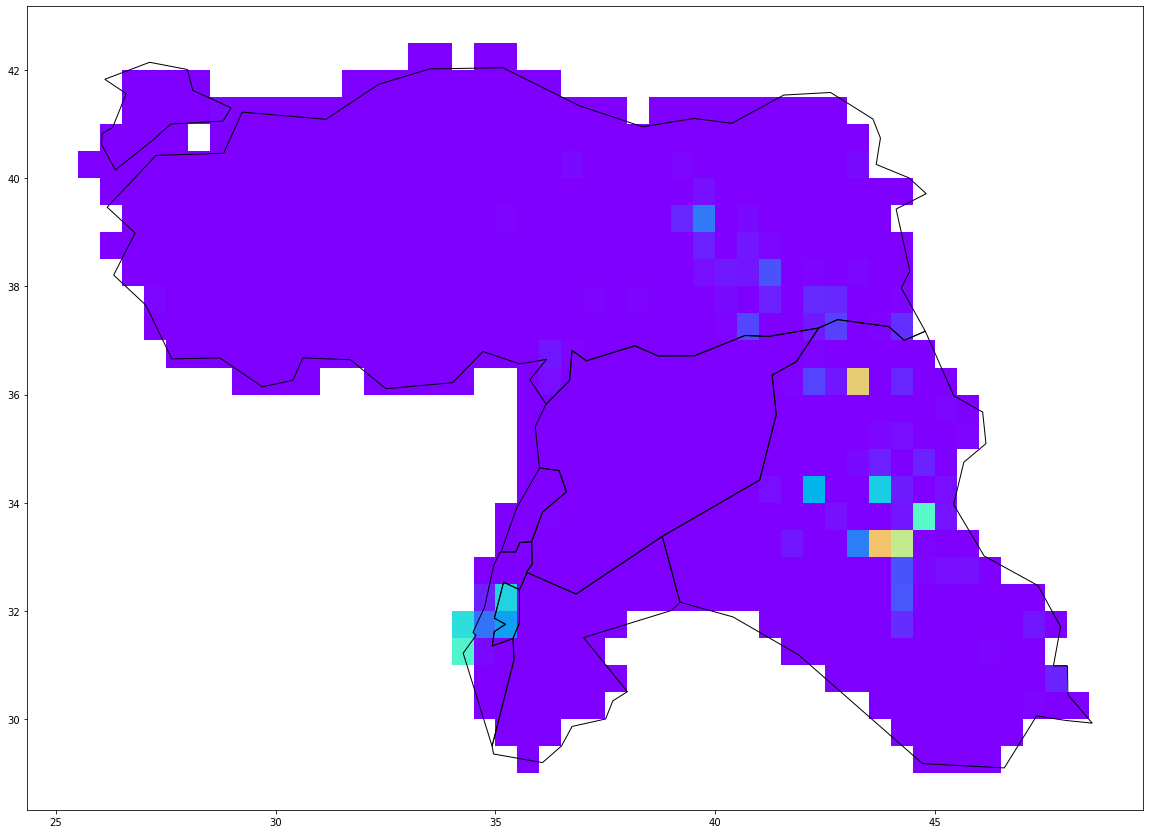

300: 2004-12


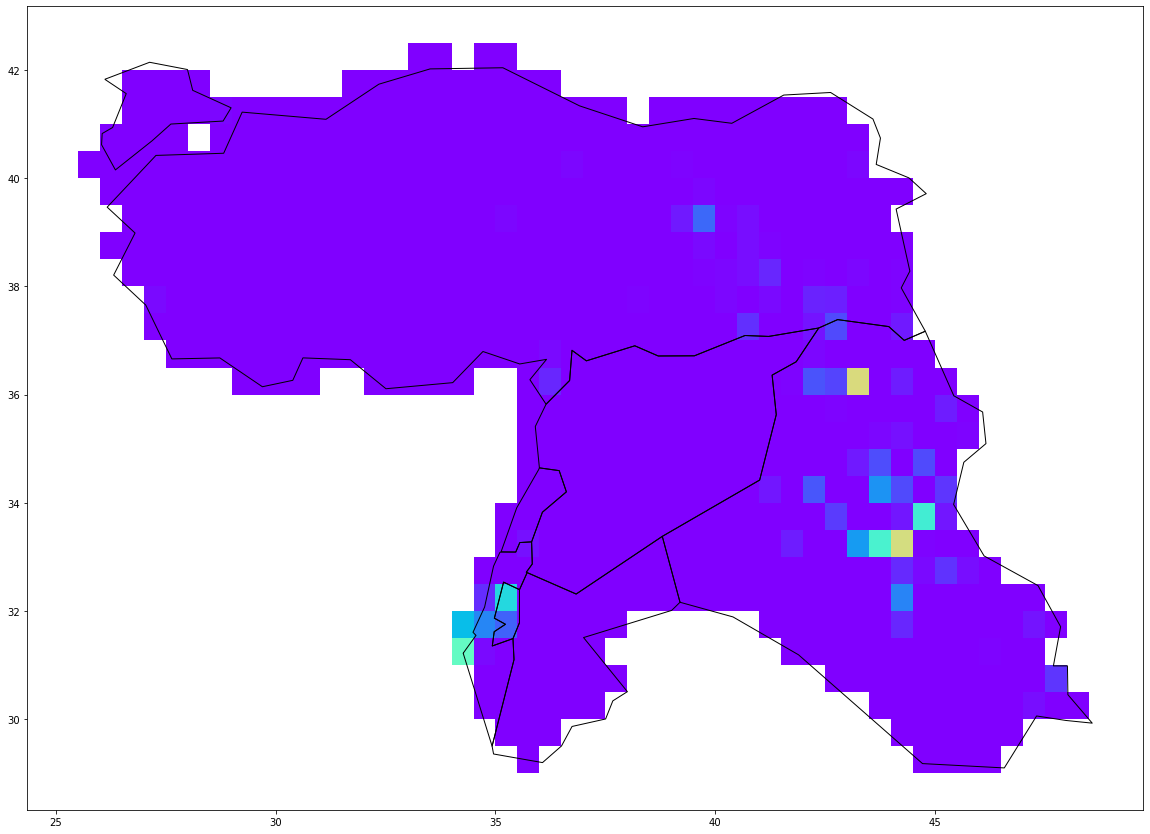

301: 2005-01


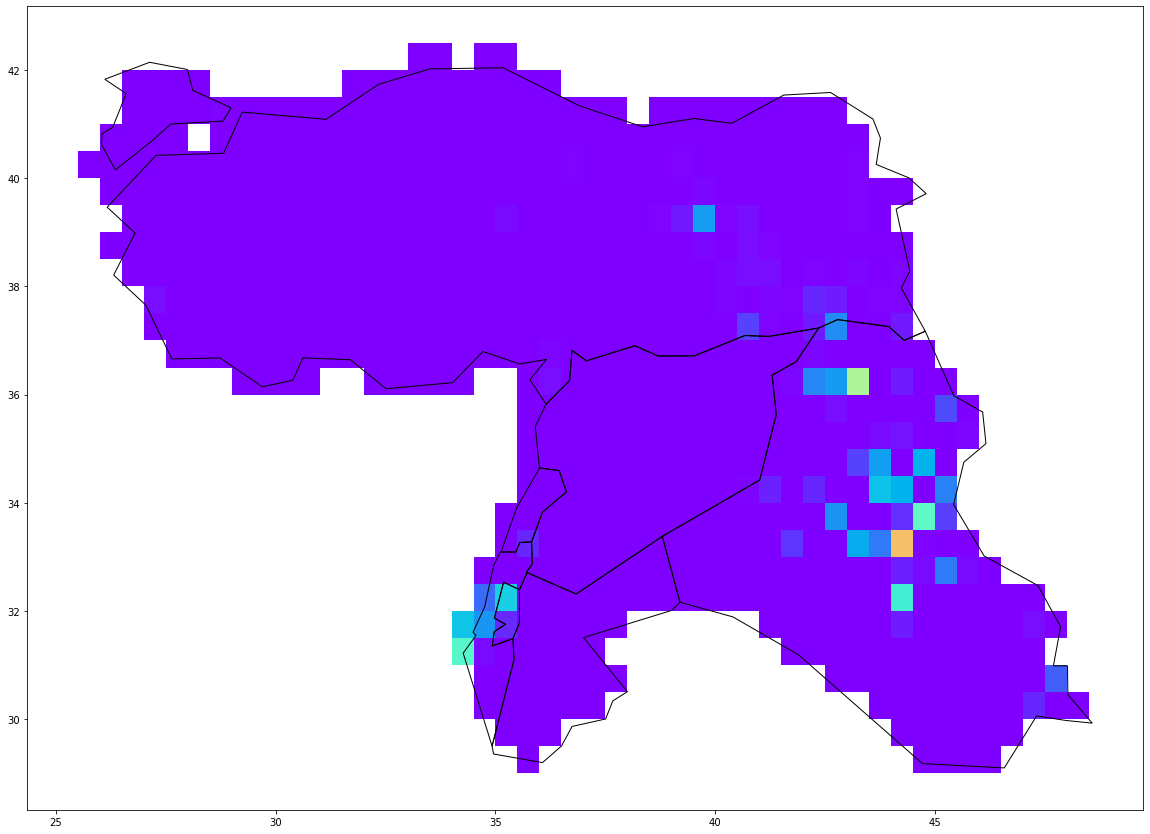

302: 2005-02


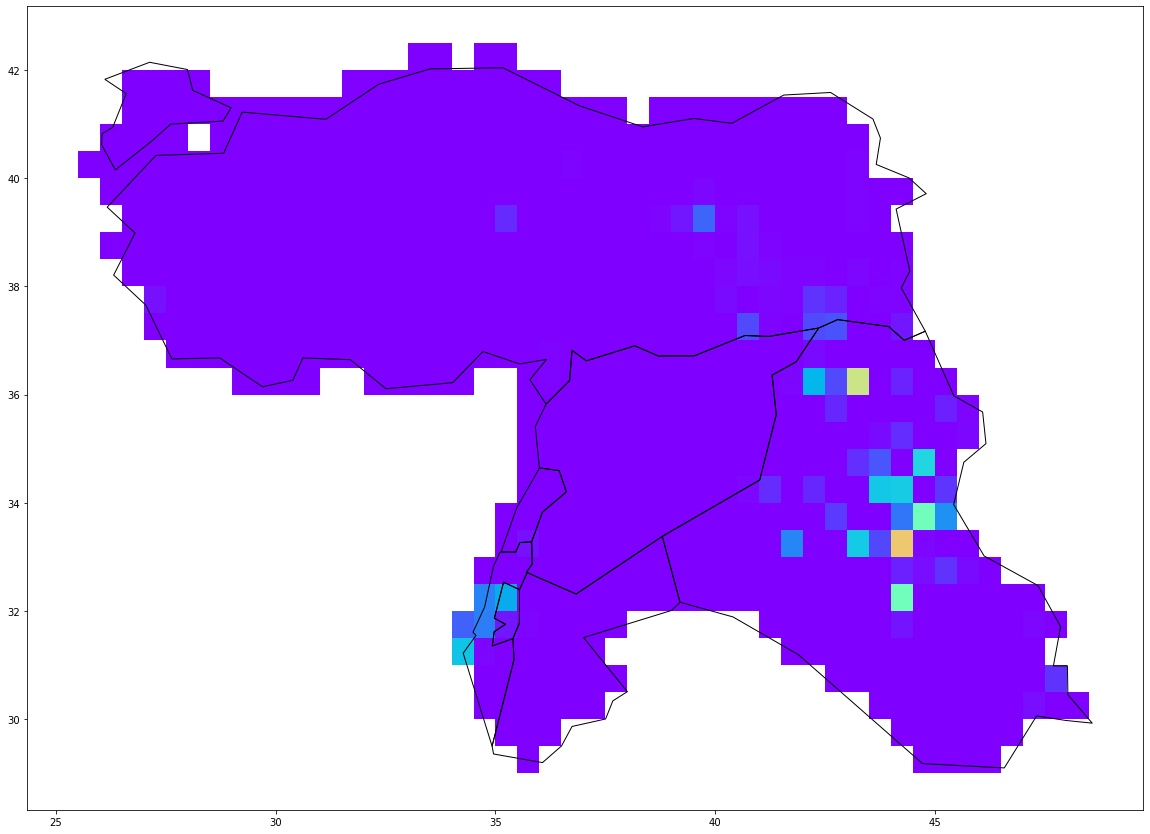

303: 2005-03


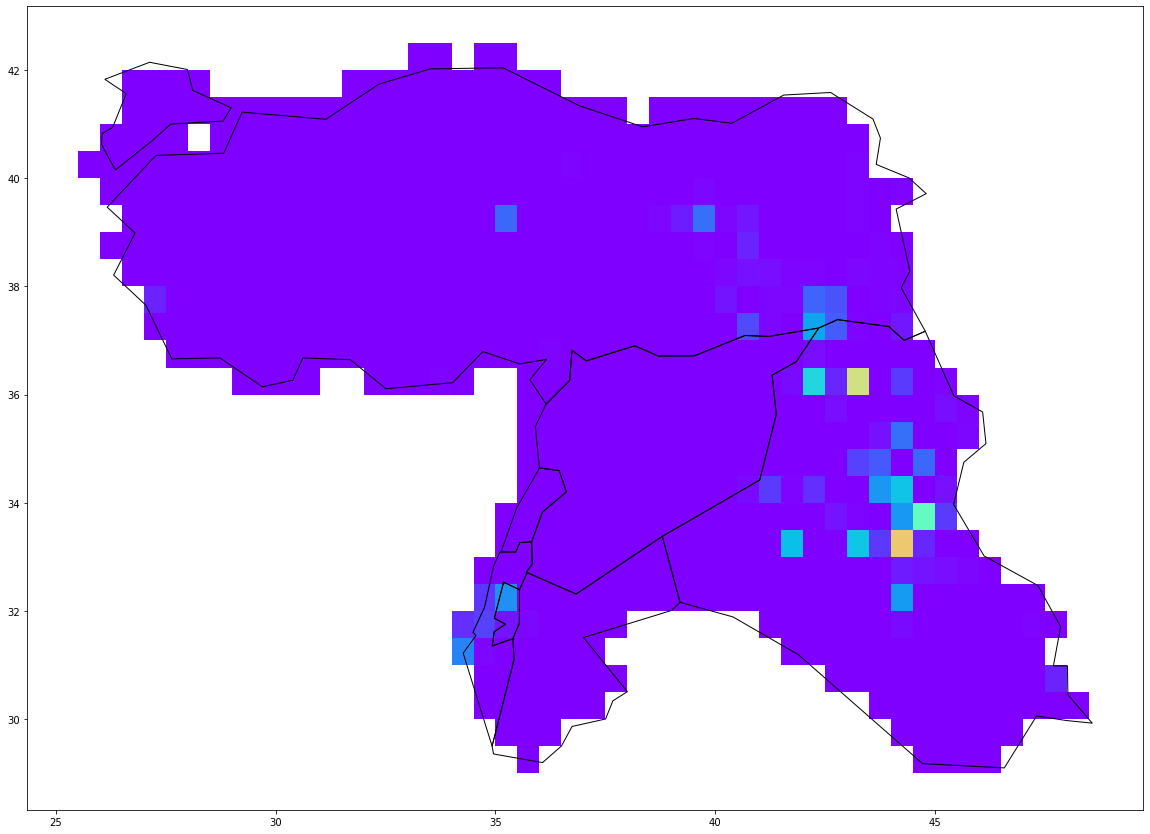

304: 2005-04


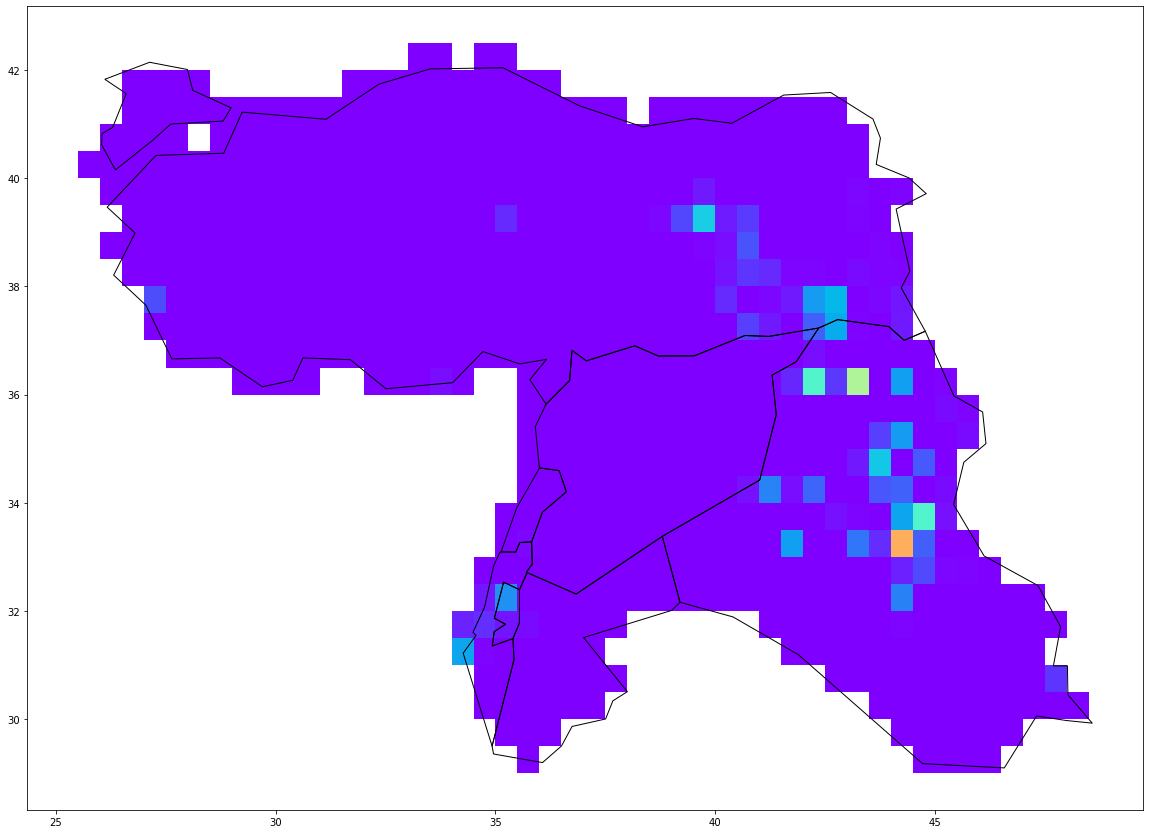

305: 2005-05


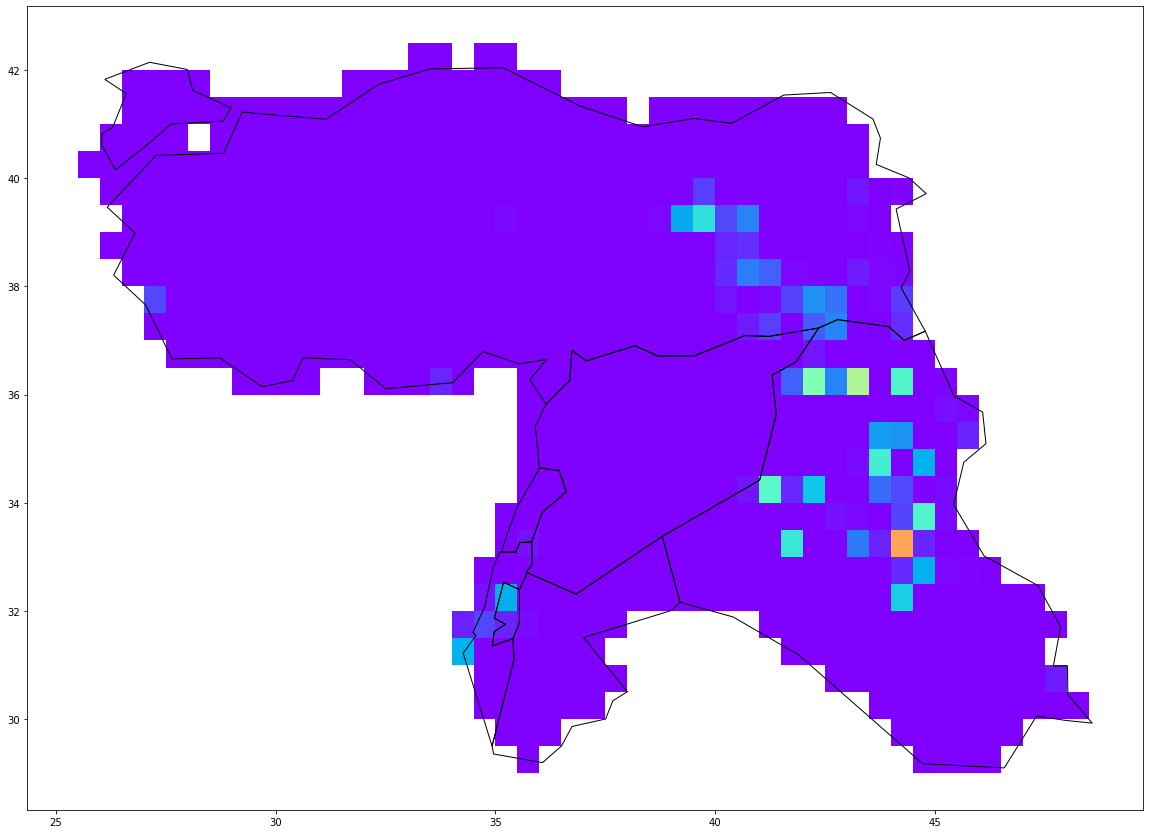

306: 2005-06


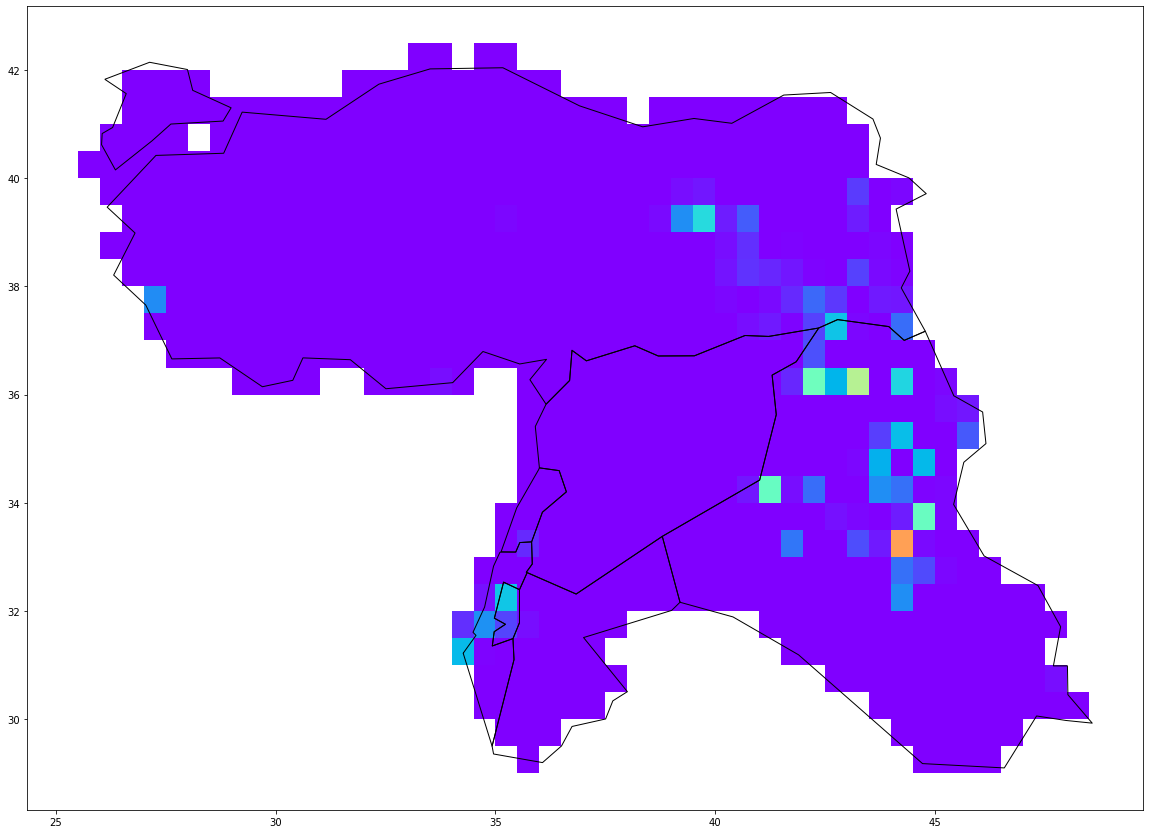

307: 2005-07


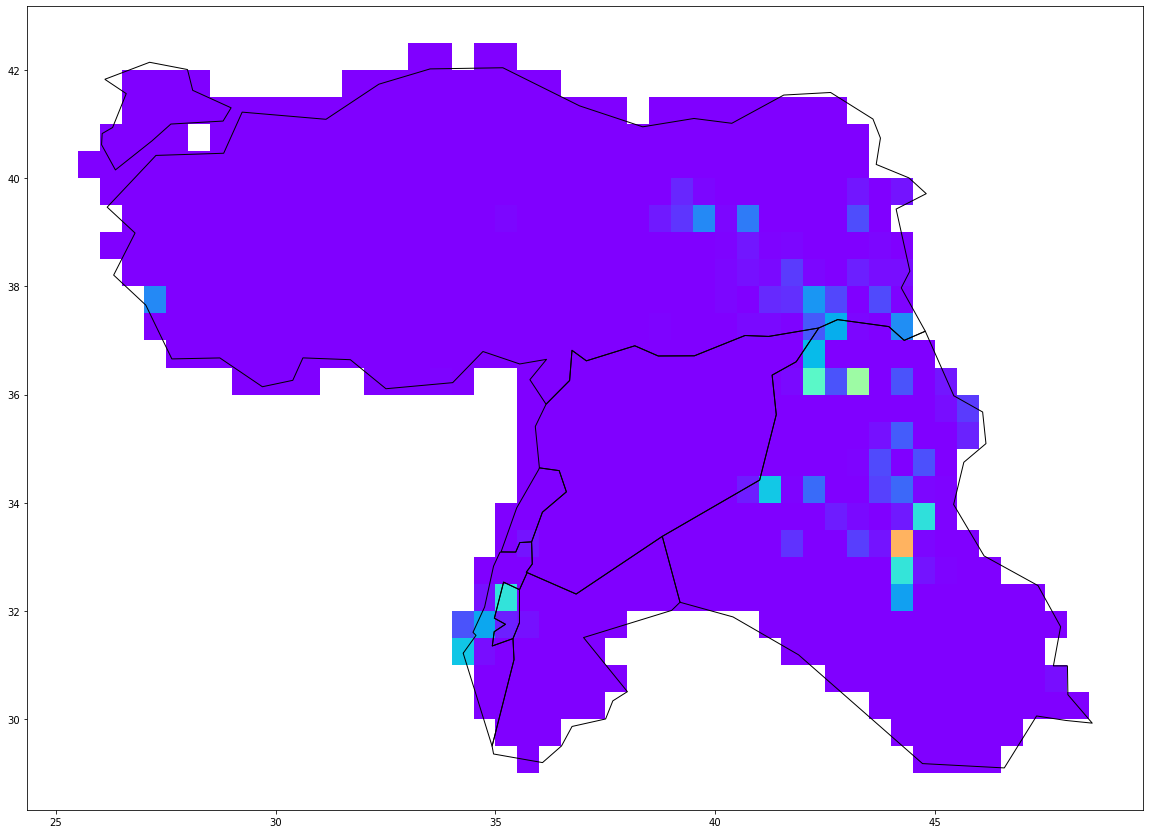

308: 2005-08


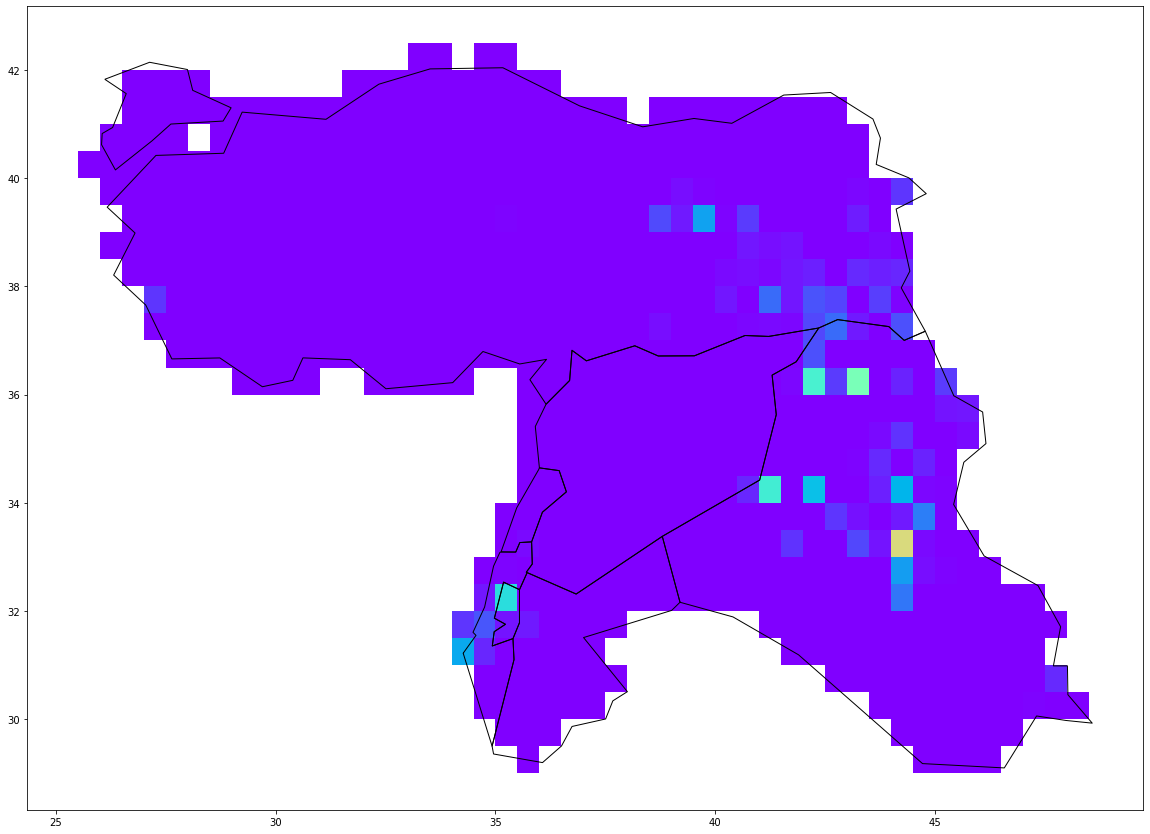

309: 2005-09


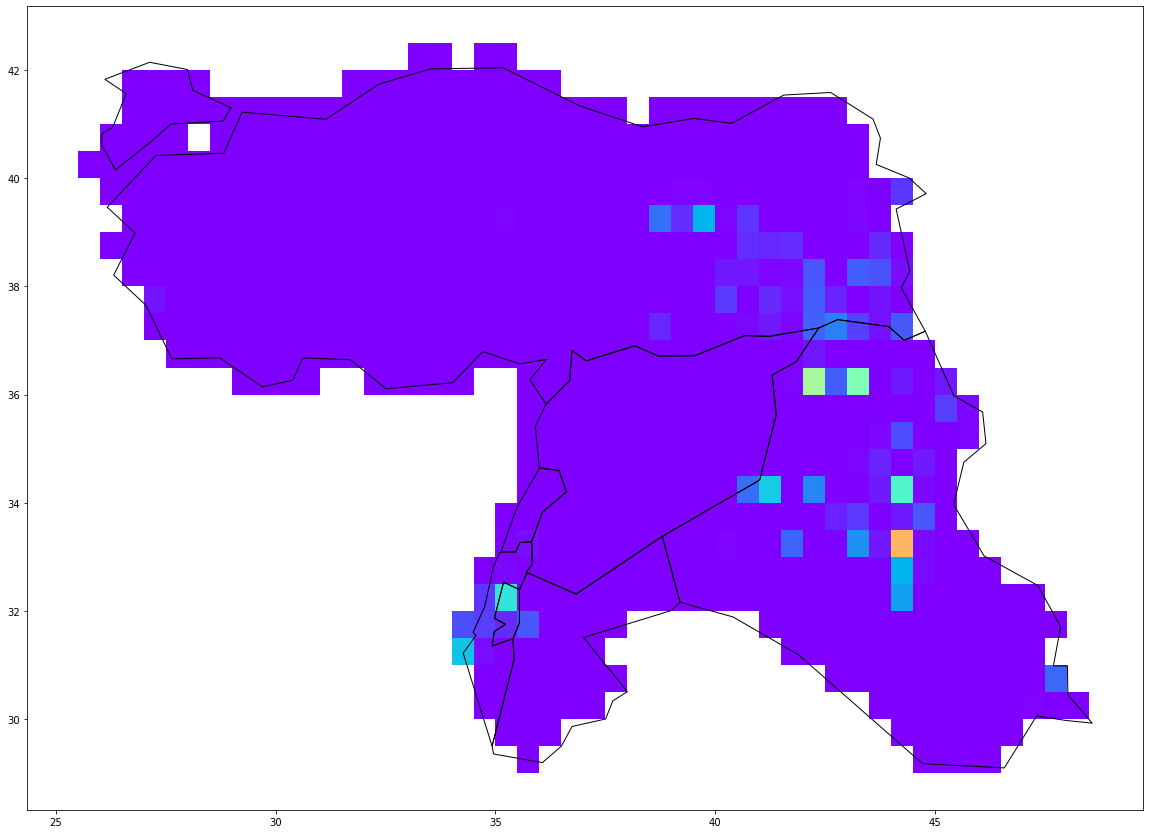

310: 2005-10


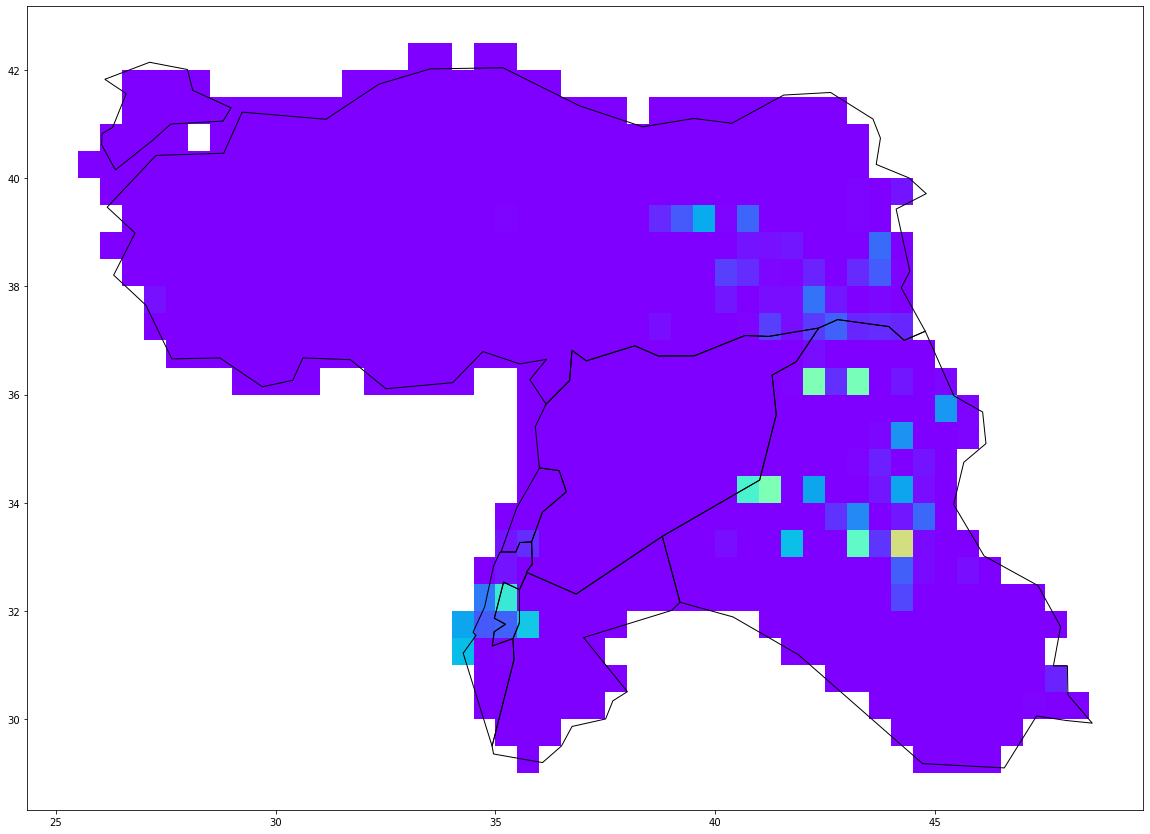

311: 2005-11


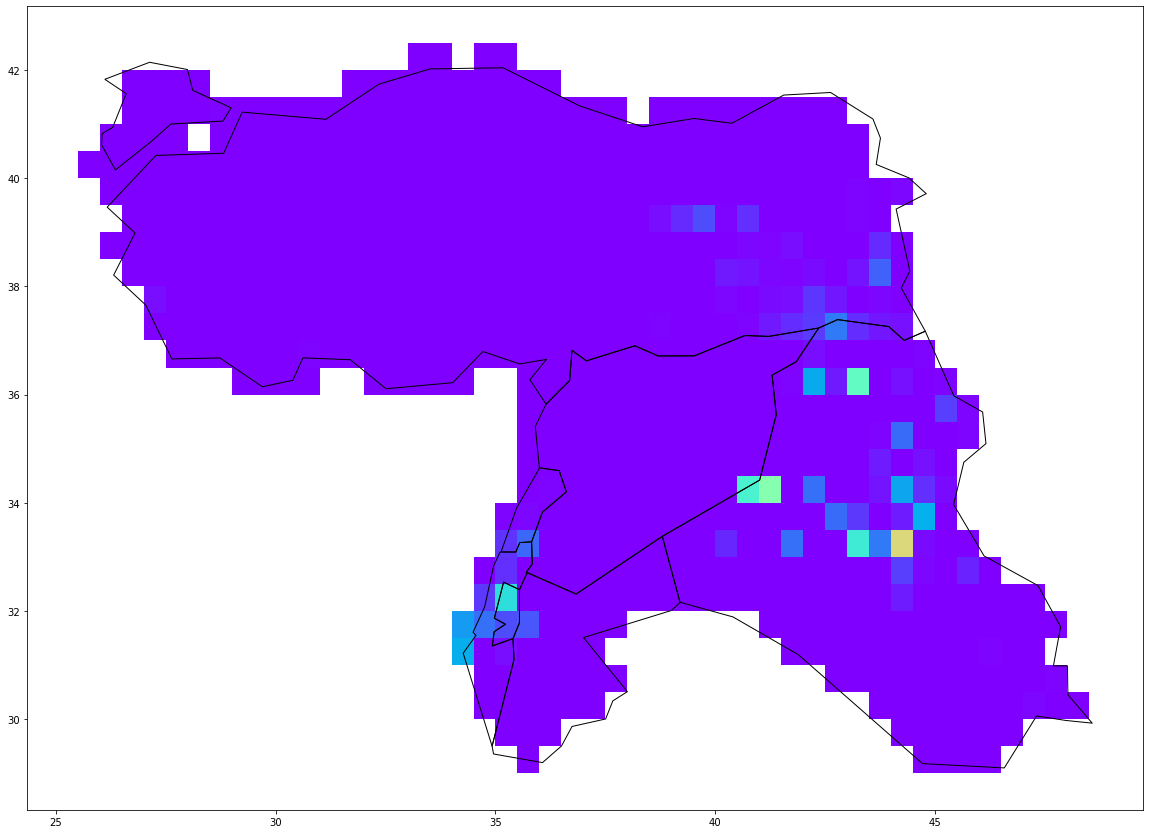

312: 2005-12


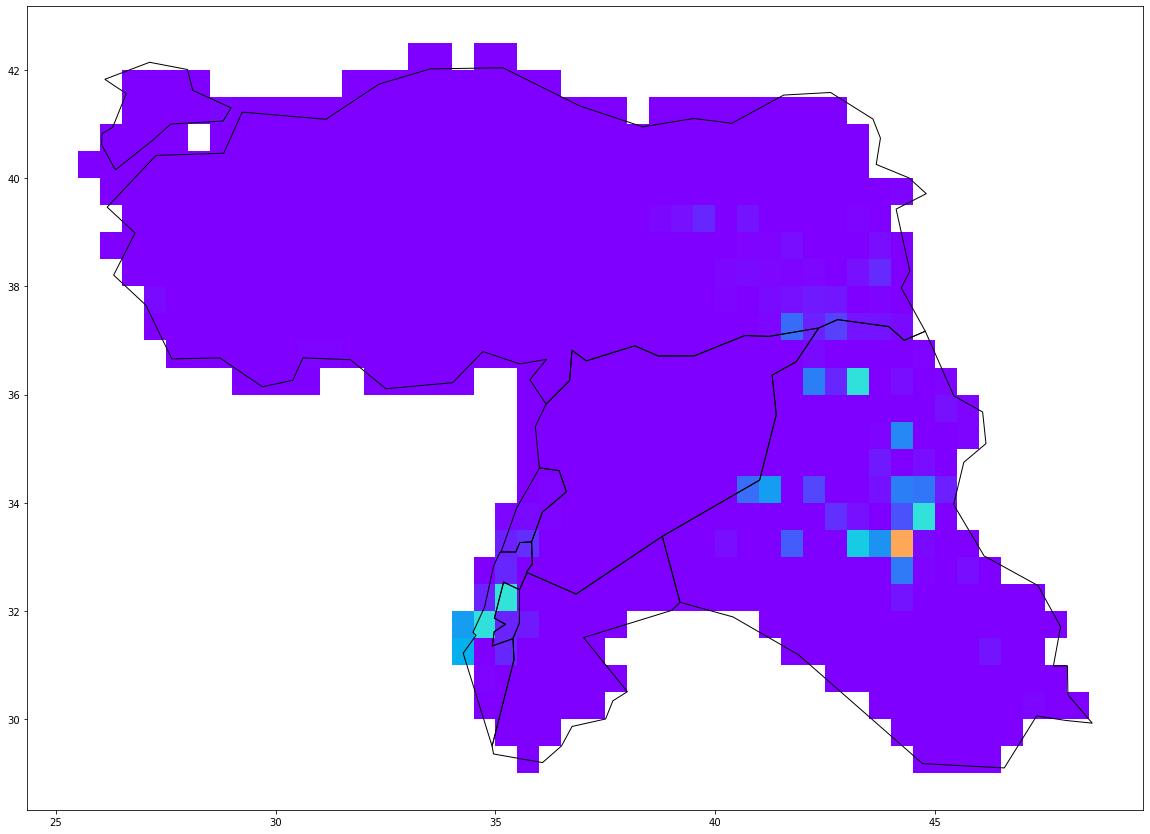

313: 2006-01


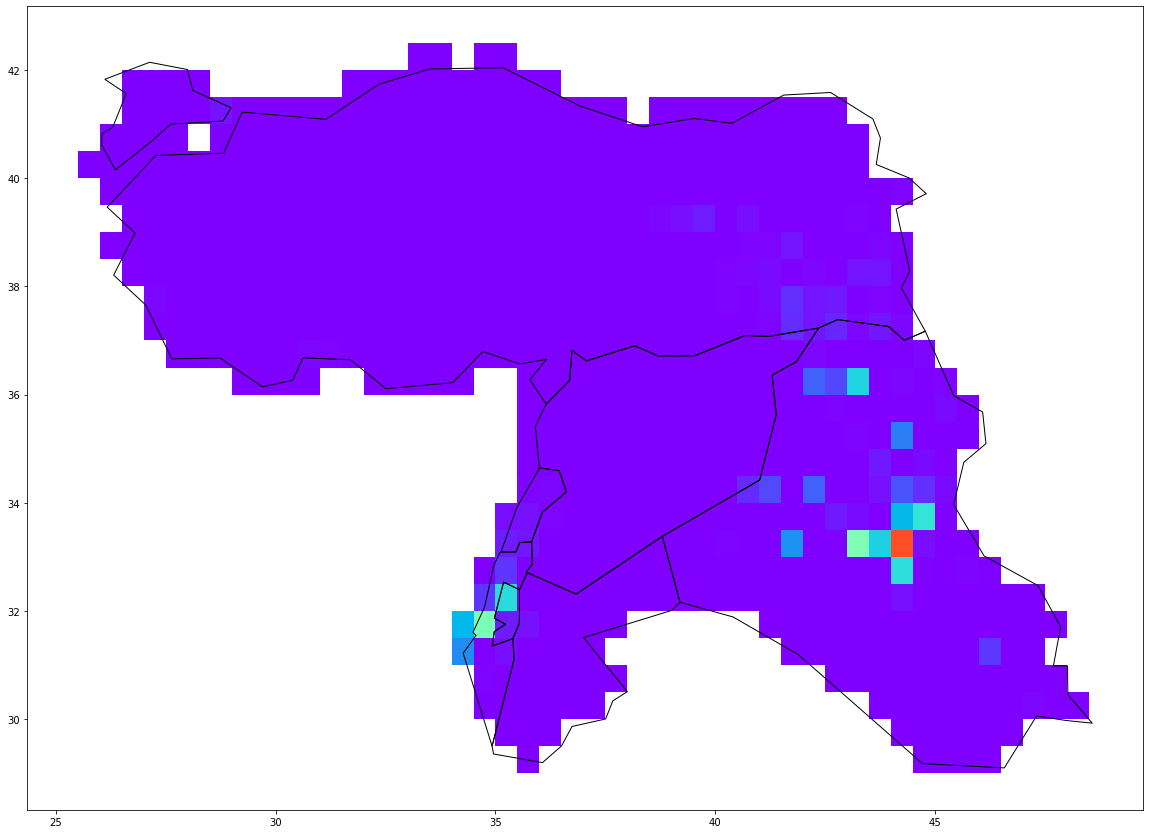

314: 2006-02


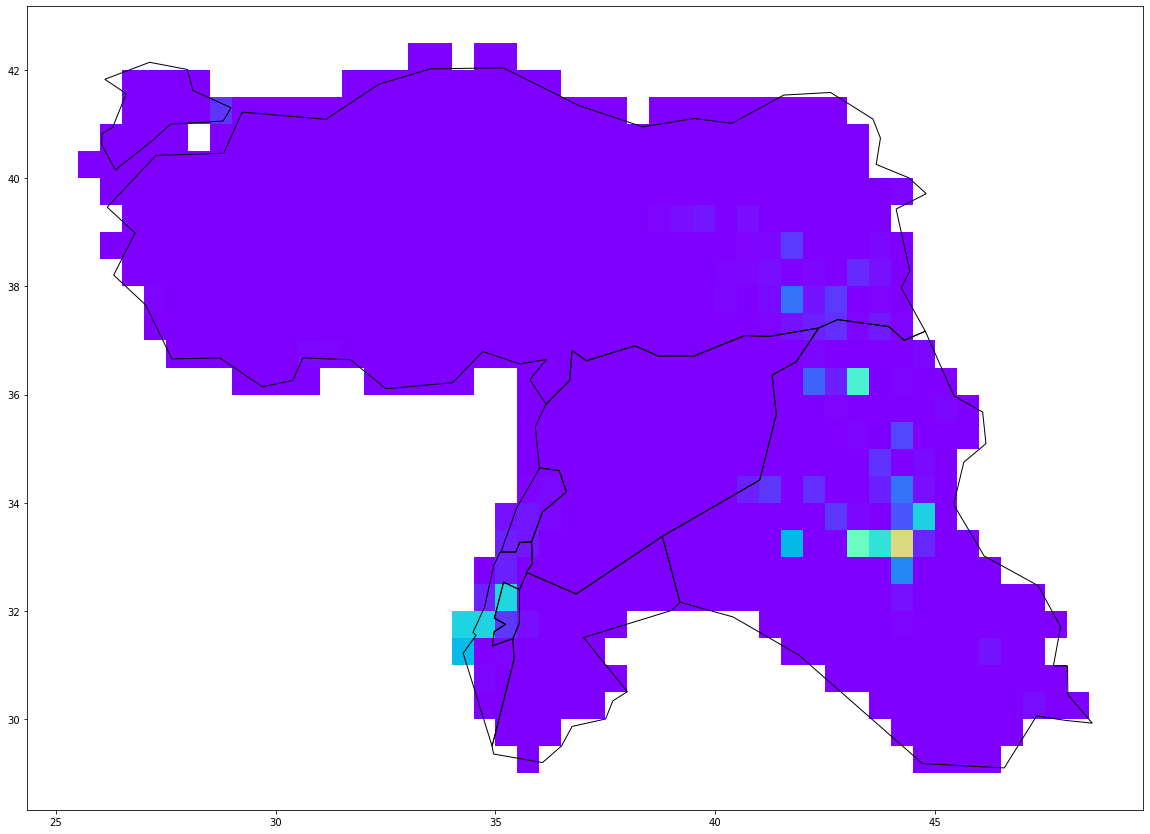

315: 2006-03


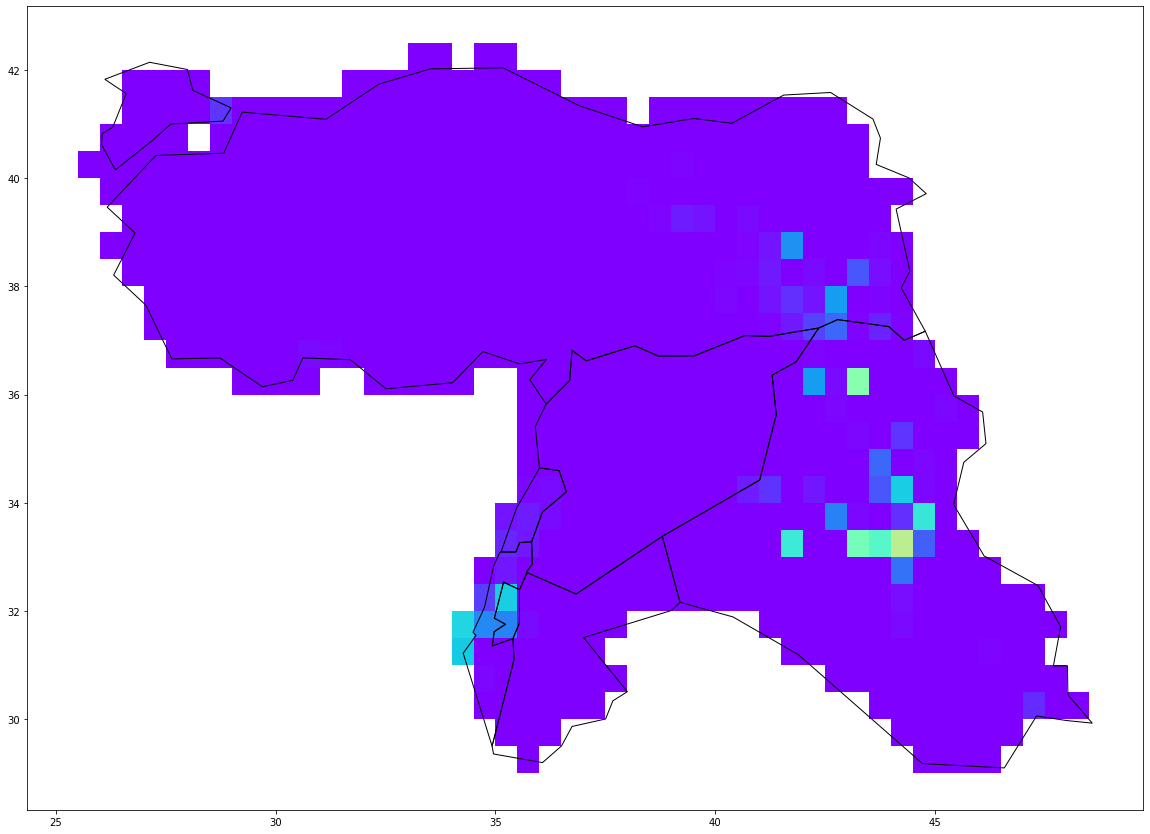

316: 2006-04


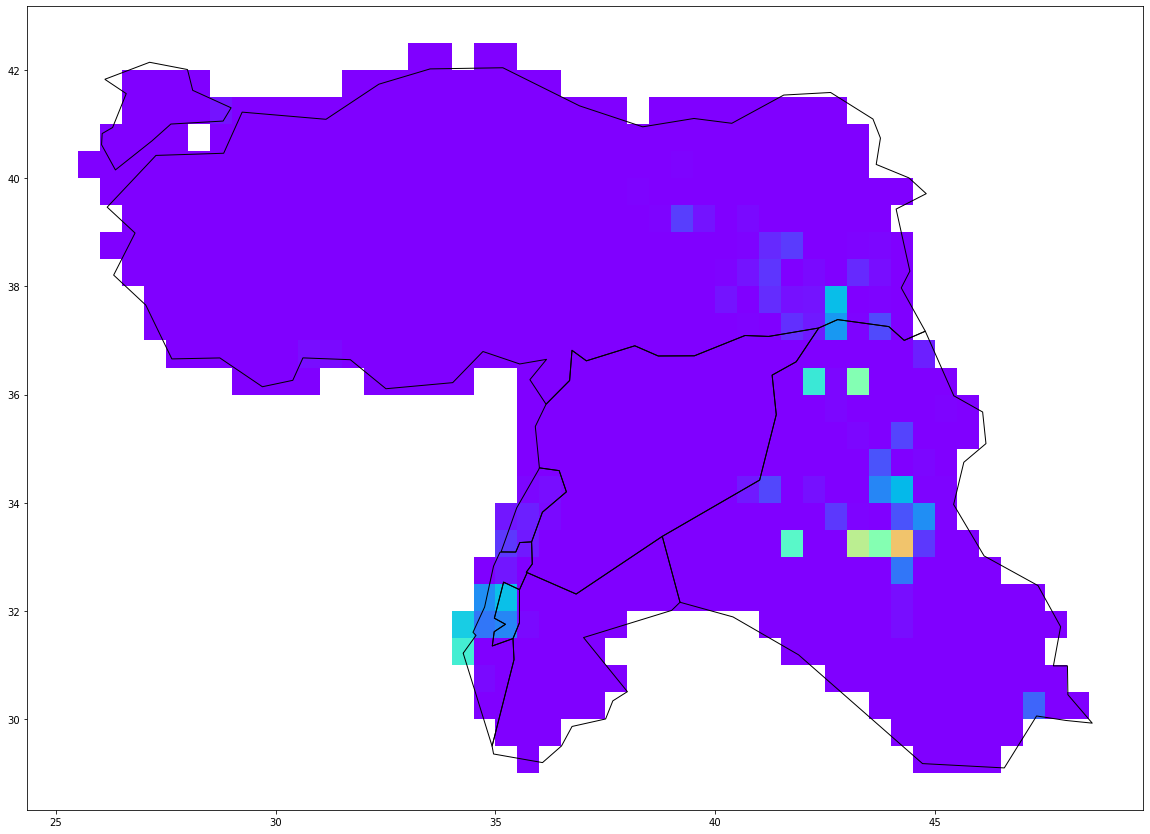

317: 2006-05


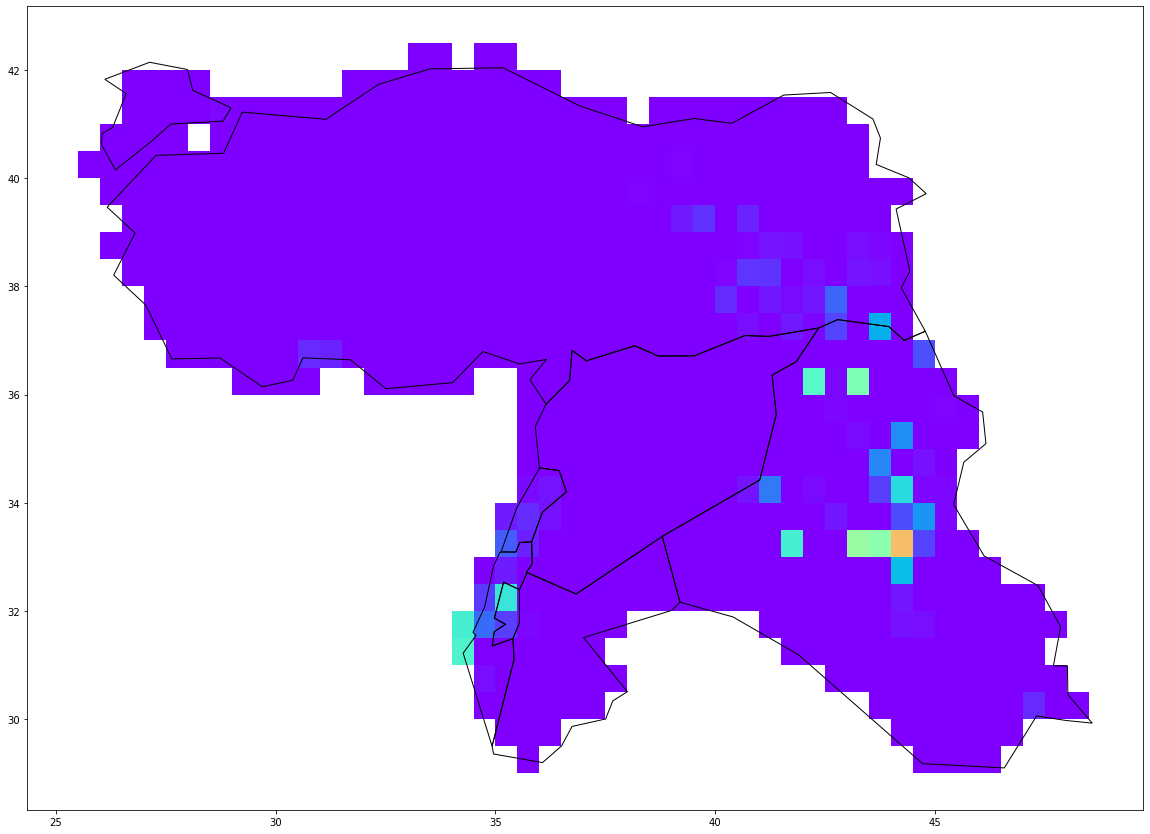

318: 2006-06


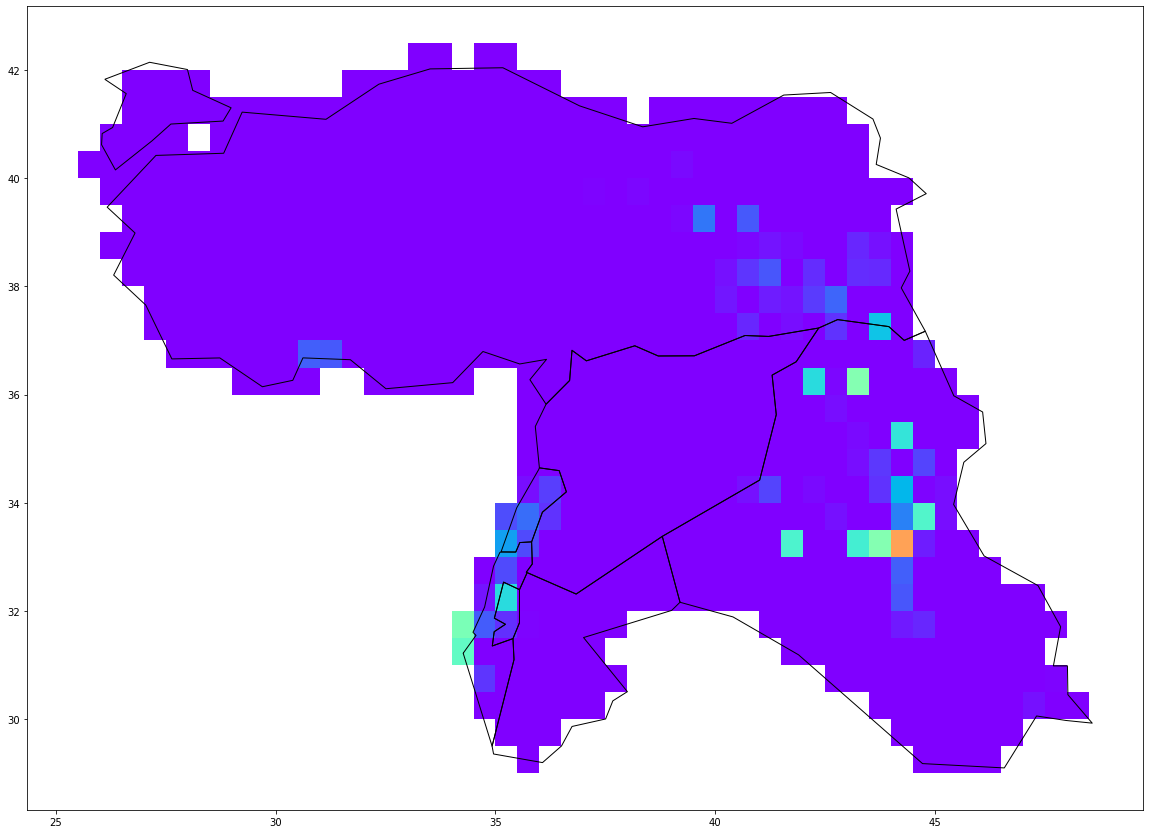

319: 2006-07


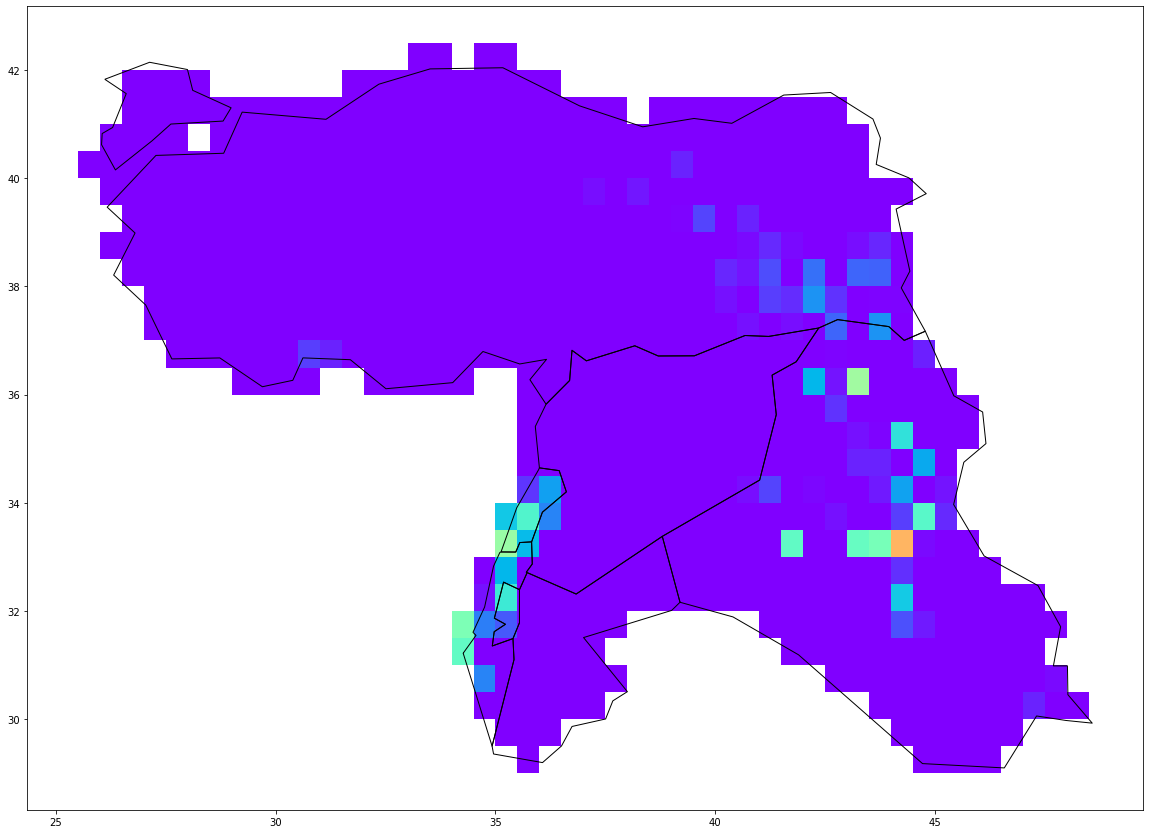

320: 2006-08


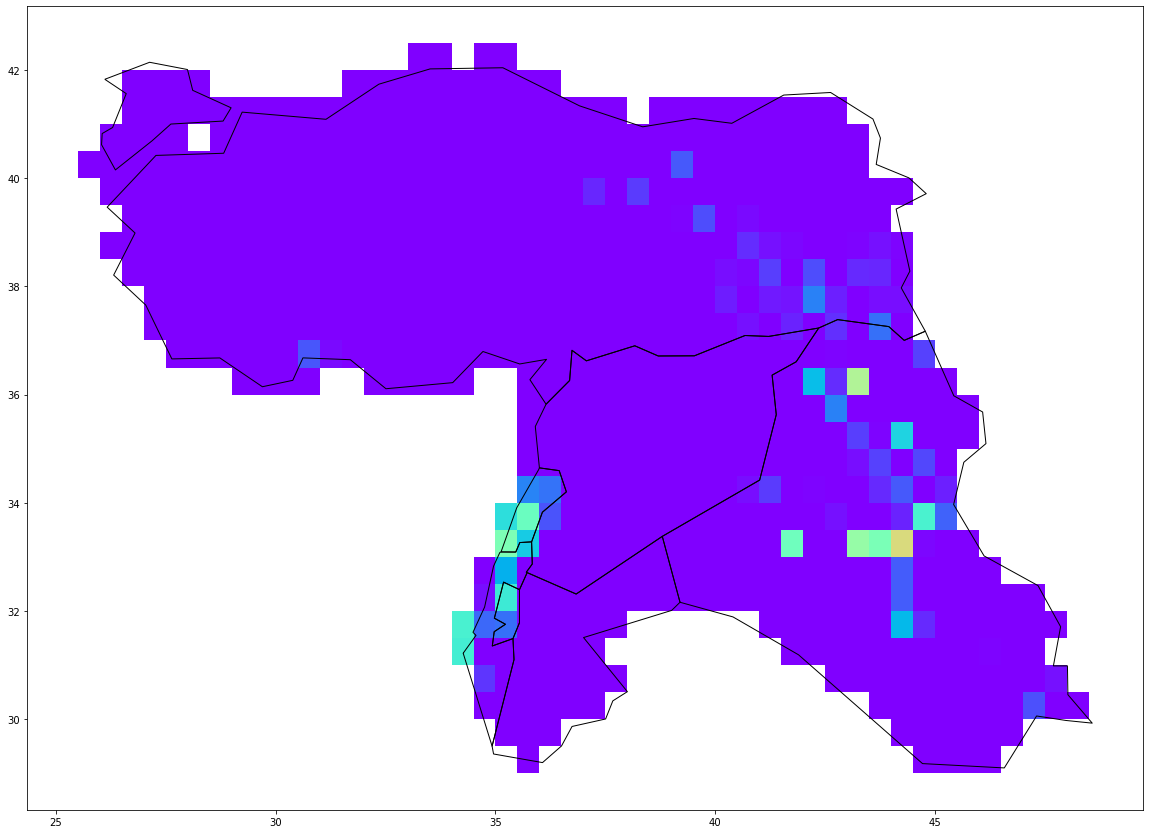

321: 2006-09


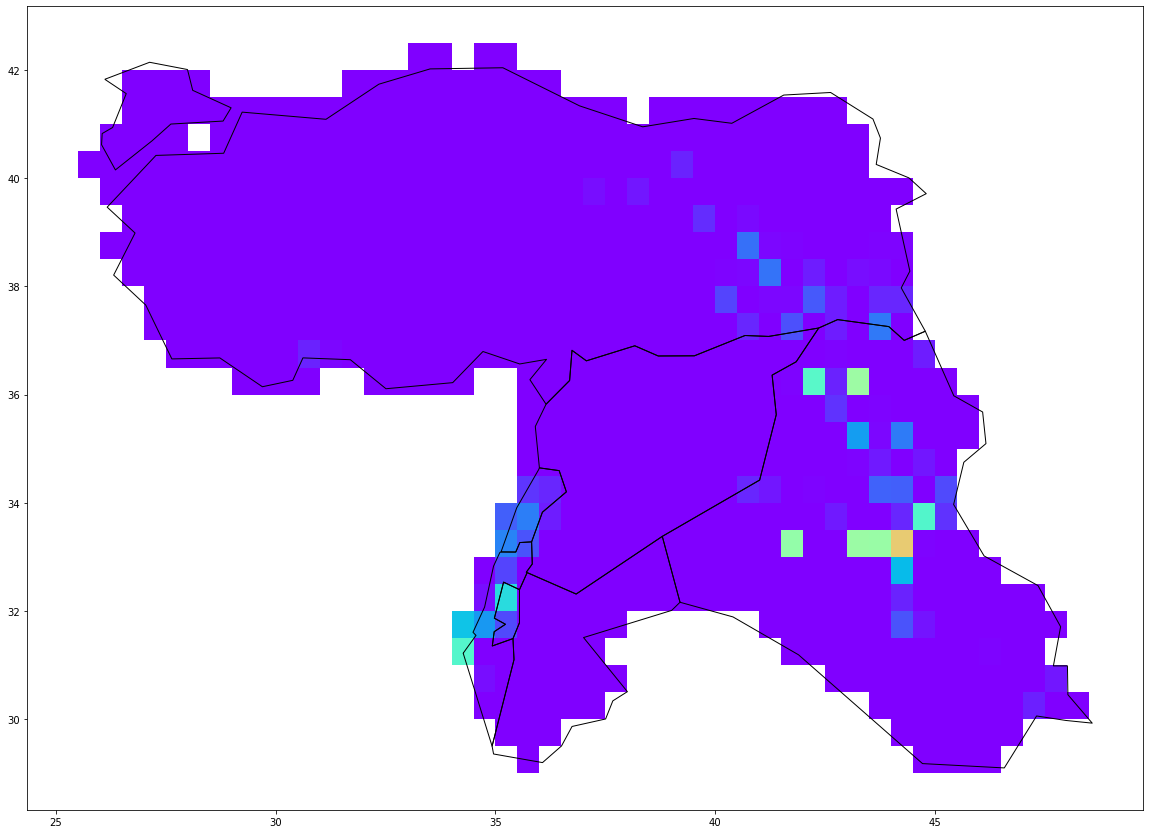

322: 2006-10


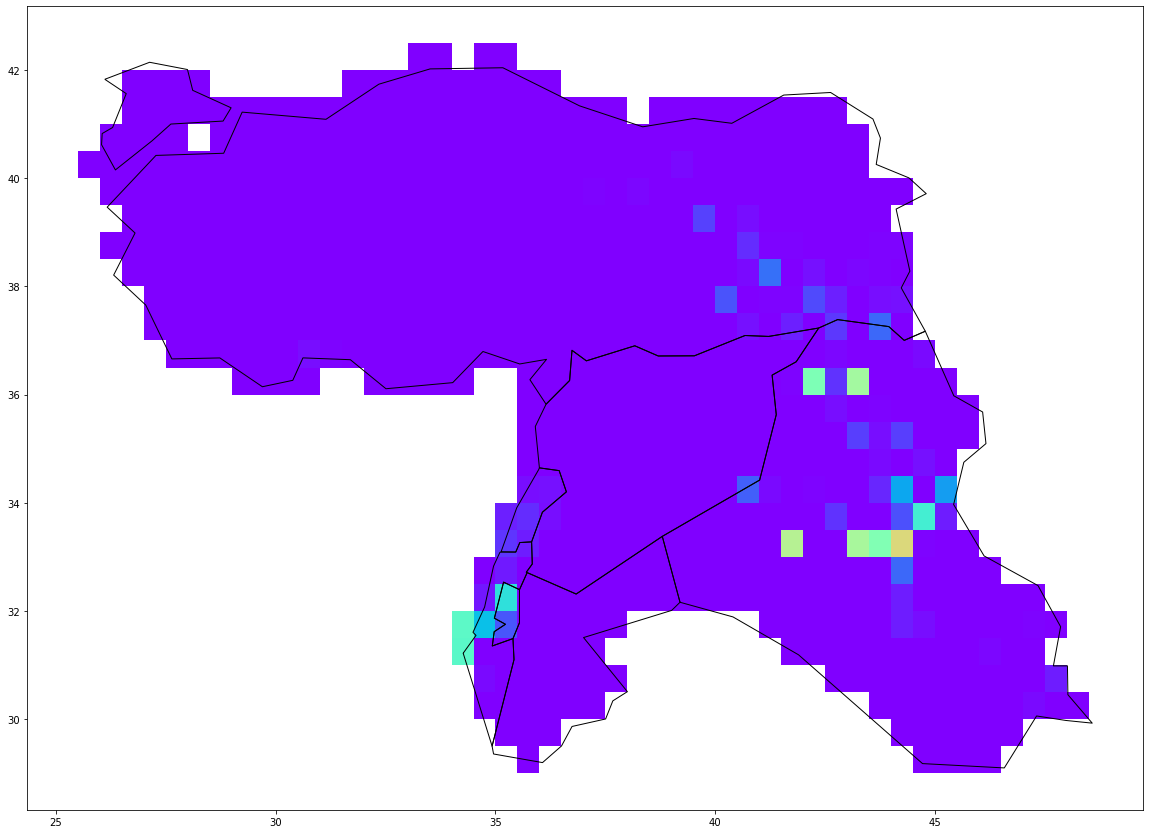

323: 2006-11


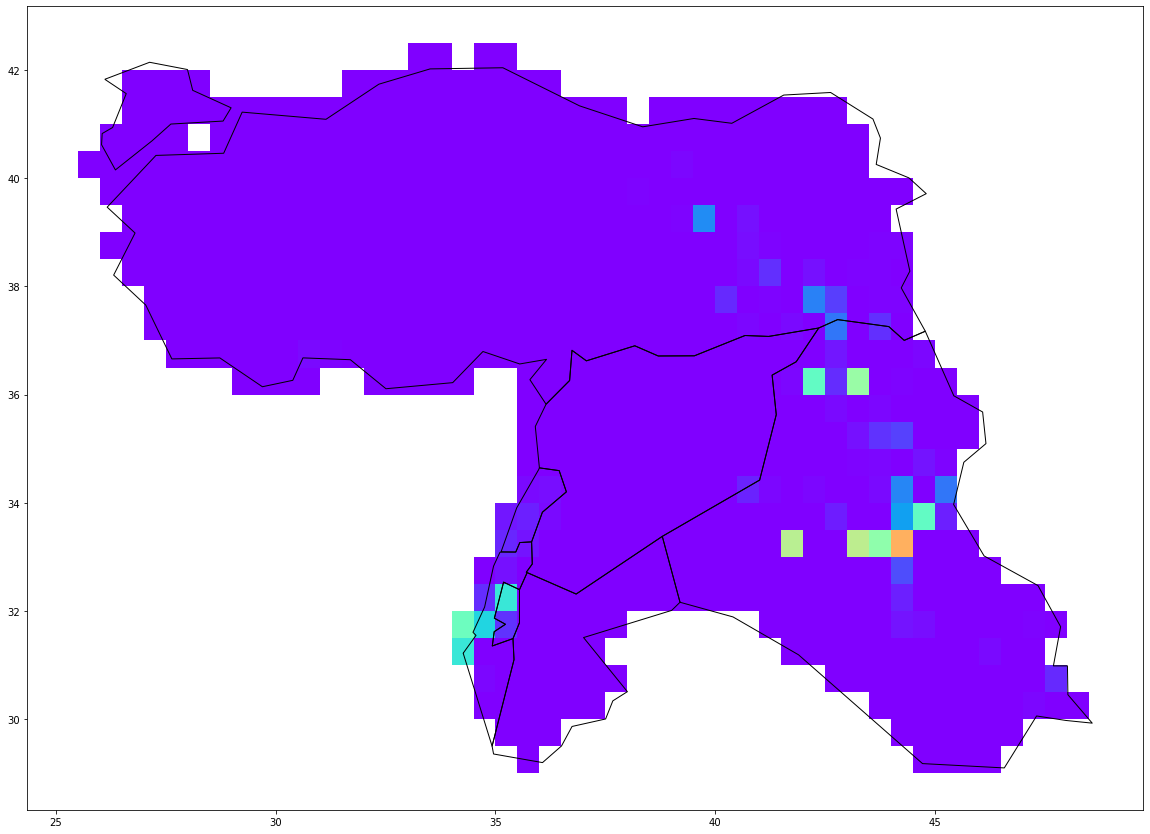

In [29]:
for i in sorted(df_sub['month_id'].unique())[180:215]:

    print(f"{i}: {df_sub[df_sub['month_id'] == i]['year_months_start'].unique().item()}")

    fig, ax = plt.subplots(figsize = (20,20))

    ax.set_aspect('equal')

    #vmax = combined_df['log_best'].max()
    vmax = df_sub.loc[(df_sub['gwno'].isin(gwno_to_keep)) & (df_sub['month_id'].isin(np.arange(180, 185+1, 1))), 'log_best'].max()

    df_sub[(df_sub['gwno'].isin(gwno_to_keep)) & (df_sub['month_id'] == i)].plot(ax = ax, column = 'tce', cmap = 'rainbow', vmin = 0, vmax = vmax)
    sub_world.plot(facecolor='none', edgecolor='black', ax=ax)
    plt.show()

# Spatial